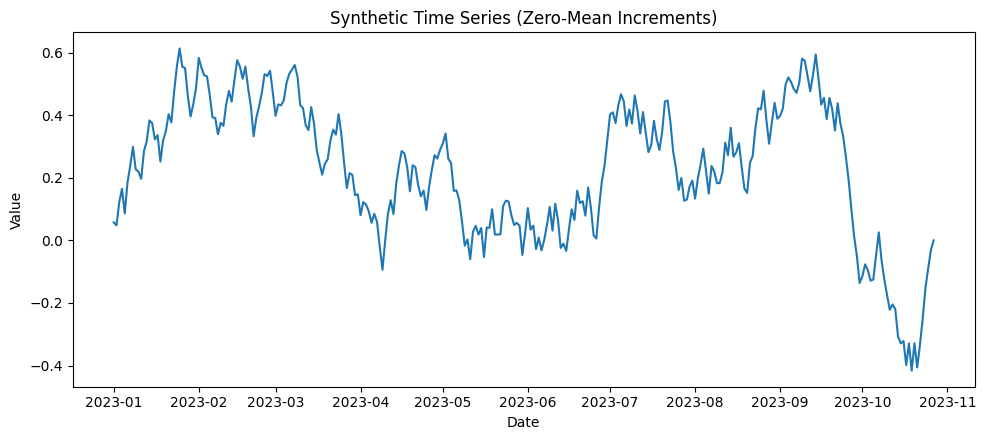

In [1]:
# zero_mean_timeseries_with_shuffle.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_zero_mean_series(n=300, drift=0.005, low=-0.1, high=0.1, seed=42):
    """
    Create a series whose *increments* have exactly zero mean.
    Start with (drift + uniform noise), then subtract the sample mean.
    """
    rng = np.random.default_rng(seed)
    noise = rng.uniform(low, high, size=n)
    raw_increments = drift + noise
    increments = raw_increments - raw_increments.mean()  # enforce zero mean
    values = np.cumsum(increments)

    dates = pd.date_range(start="2023-01-01", periods=n, freq="D")
    df = pd.DataFrame({"date": dates, "value": values})
    return df, increments

def main():
    # Generate time series with zero-mean increments
    df, increments = make_zero_mean_series(n=300, drift=0.005, low=-0.1, high=0.1, seed=42)

    # 1) Plot original time series (with dates)
    plt.figure(figsize=(10, 4.5))
    plt.plot(df["date"], df["value"])
    plt.title("Synthetic Time Series (Zero-Mean Increments)")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


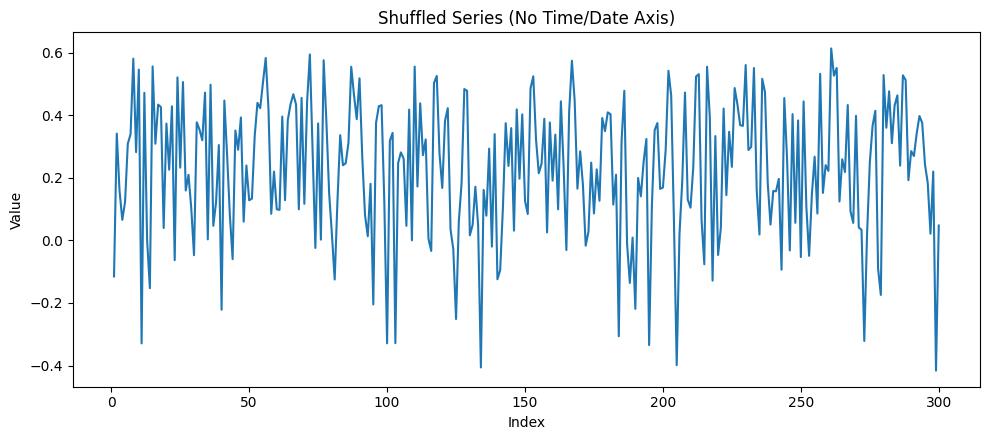

In [2]:
def main():
    # Generate time series with zero-mean increments
    df, increments = make_zero_mean_series(n=300, drift=0.005, low=-0.1, high=0.1, seed=42)

    # 2) Shuffle the values and plot again without timestamps
    rng = np.random.default_rng(123)
    shuffled_values = rng.permutation(df["value"].to_numpy())

    plt.figure(figsize=(10, 4.5))
    plt.plot(np.arange(1, len(shuffled_values) + 1), shuffled_values)
    plt.title("Shuffled Series (No Time/Date Axis)")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

    # (Optional) Quick checks
    # print(f"Mean of increments (should be 0): {increments.mean():.6f}")

if __name__ == "__main__":
    main()

/var/folders/yp/6mn1n00s6zg4_6vww8ksl5tw0000gn/T/ipykernel_63362/898696061.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range("2005-01-01", periods=n, freq="M")


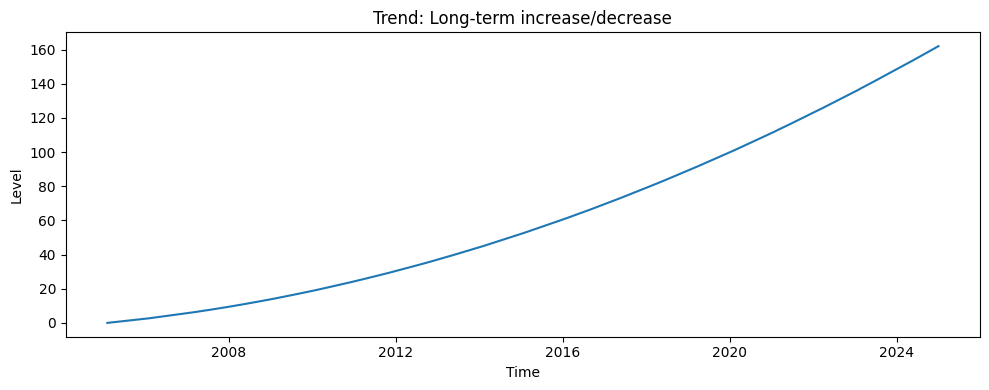

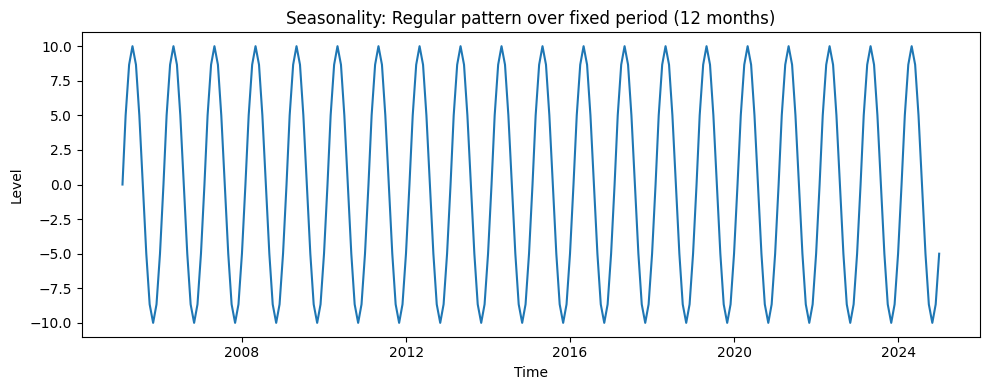

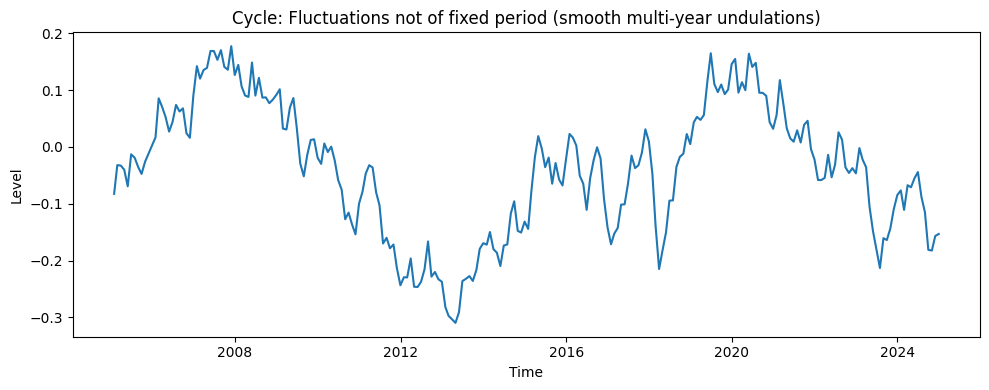

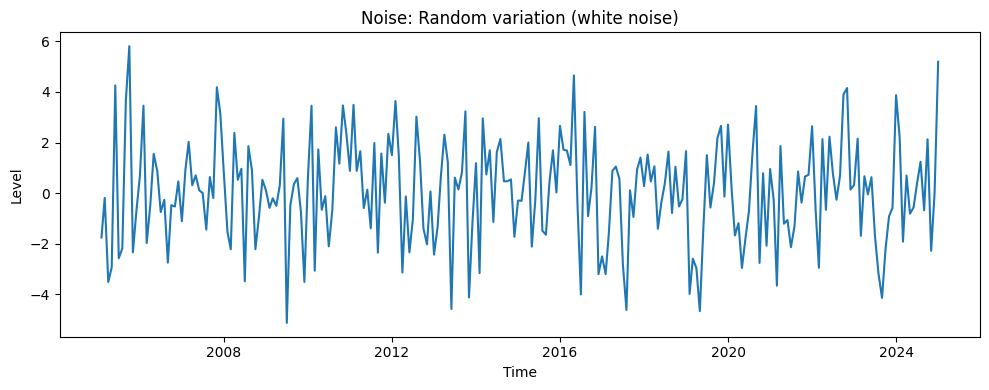

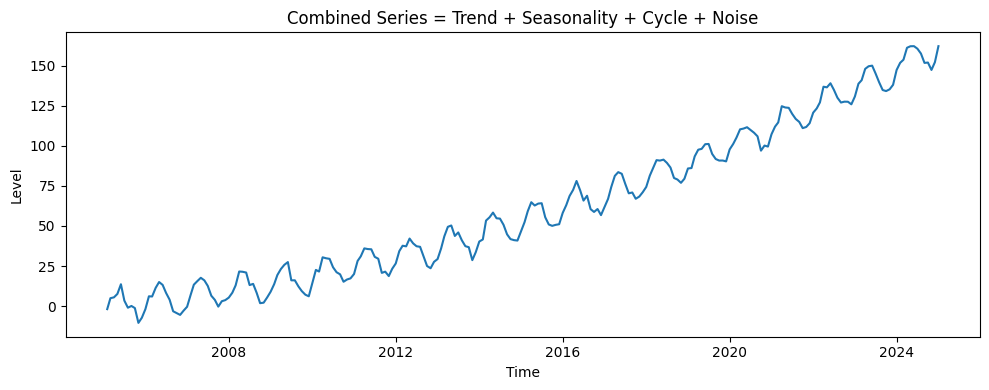

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
n = 240
idx = pd.date_range("2005-01-01", periods=n, freq="M")
t = np.arange(n)

# Components
trend = 0.2 * t + 0.002 * (t**2)                   # long-term increase (slightly nonlinear)
seasonality = 10 * np.sin(2 * np.pi * t / 12)      # fixed 12-month pattern
raw_cycle = rng.normal(0, 1, n)                     # cycle: smooth undulations, no fixed period
cycle = pd.Series(raw_cycle).rolling(window=36, min_periods=1, center=True).mean().to_numpy()
noise = rng.normal(0, 2, n)                         # random variation

y = trend + seasonality + cycle + noise             # combined series

def plot_series(x, y, title, ylabel="Level"):
    plt.figure(figsize=(10, 4))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

plot_series(idx, trend, "Trend: Long-term increase/decrease")
plot_series(idx, seasonality, "Seasonality: Regular pattern over fixed period (12 months)")
plot_series(idx, cycle, "Cycle: Fluctuations not of fixed period (smooth multi-year undulations)")
plot_series(idx, noise, "Noise: Random variation (white noise)")
plot_series(idx, y, "Combined Series = Trend + Seasonality + Cycle + Noise")


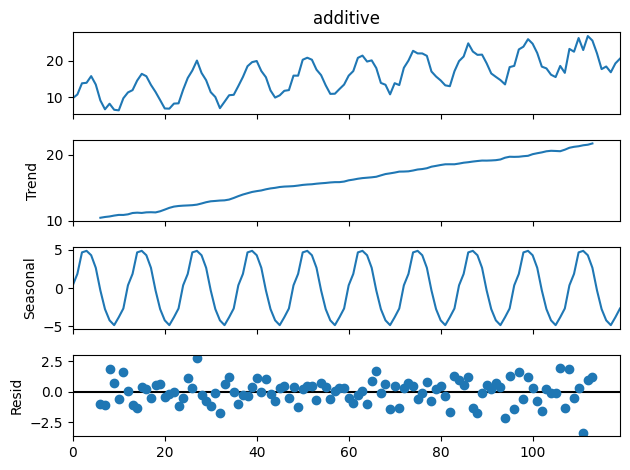

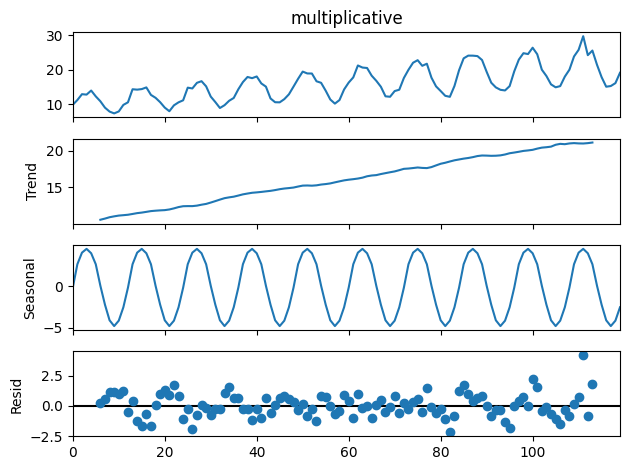

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example: Simulate additive vs multiplicative
t = np.arange(0, 120)
additive = 10 + 0.1*t + 5*np.sin(2*np.pi*t/12) + np.random.normal(0,1,len(t))
multiplicative = (10 + 0.1*t) * (1 + 0.3*np.sin(2*np.pi*t/12)) * np.random.normal(1,0.05,len(t))

df = pd.DataFrame({
    "additive": additive,
    "multiplicative": multiplicative
})

# Decompose both and plot
for col in df.columns:
    result = seasonal_decompose(df[col], model='additive', period=12)
    result.plot()
    # plt.suptitle(f"{col.title()} Series – Additive Decomposition")
    plt.show()


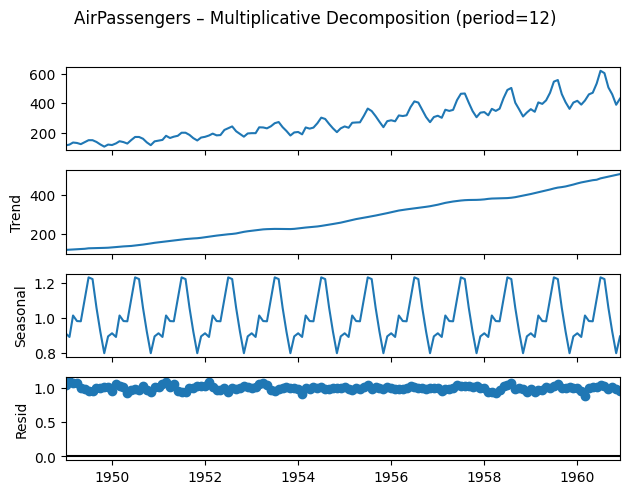

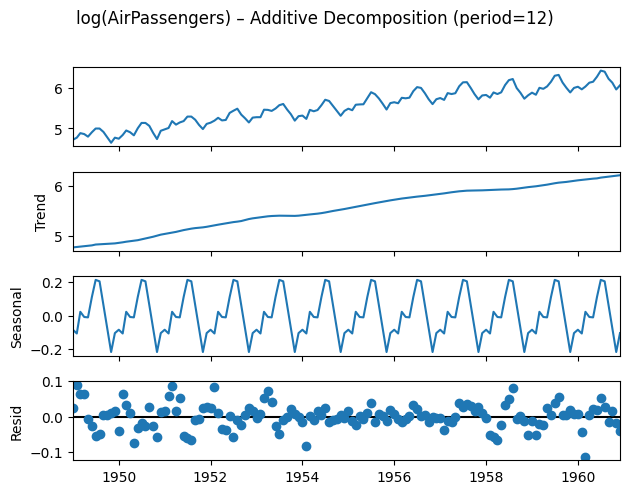

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# -----------------------------
# 1) Load AirPassengers (R ds)
# -----------------------------
df = sm.datasets.get_rdataset("AirPassengers").data  # columns: ['time', 'value']

# Build a proper monthly DatetimeIndex from the fractional 'time' column
# Example: 1949.000 -> Jan 1949, 1949.083... -> Feb 1949, etc.
t = df['time'].to_numpy()
years = np.floor(t).astype(int)
months = np.round((t - years) * 12).astype(int) + 1  # 1..12

# Guard against floating artifacts (e.g., 13 -> 12)
months = np.clip(months, 1, 12)

dates = pd.to_datetime(
    pd.DataFrame({'year': years, 'month': months, 'day': 1})
)
y = pd.Series(df['value'].to_numpy(), index=dates).asfreq('MS')  # monthly start

# ---------------------------------------------
# 2) Multiplicative decomposition on raw series
# ---------------------------------------------
mul = seasonal_decompose(y, model='multiplicative', period=12, extrapolate_trend='freq')
fig1 = mul.plot()
fig1.suptitle("AirPassengers – Multiplicative Decomposition (period=12)", y=1.02)
plt.tight_layout()

# ----------------------------------------------------------
# 3) Log transform, then additive decomposition (stabilize var)
# ----------------------------------------------------------
y_log = np.log(y)
add = seasonal_decompose(y_log, model='additive', period=12, extrapolate_trend='freq')
fig2 = add.plot()
fig2.suptitle("log(AirPassengers) – Additive Decomposition (period=12)", y=1.02)
plt.tight_layout()

plt.show()

# Notes:
# - Multiplicative is suited when seasonal amplitude grows with level (true here).
# - log() stabilizes variance so additive decomposition becomes appropriate.
# - period=12 for annual seasonality in monthly data.


In [6]:
# first twelve values of multiplicative seasonal vector:
mul.seasonal[0:12]

1949-01-01    0.911256
1949-02-01    0.890342
1949-03-01    1.012397
1949-04-01    0.980719
1949-05-01    0.979495
1949-06-01    1.108310
1949-07-01    1.229422
1949-08-01    1.219640
1949-09-01    1.056262
1949-10-01    0.920694
1949-11-01    0.797882
1949-12-01    0.893580
Freq: MS, Name: seasonal, dtype: float64

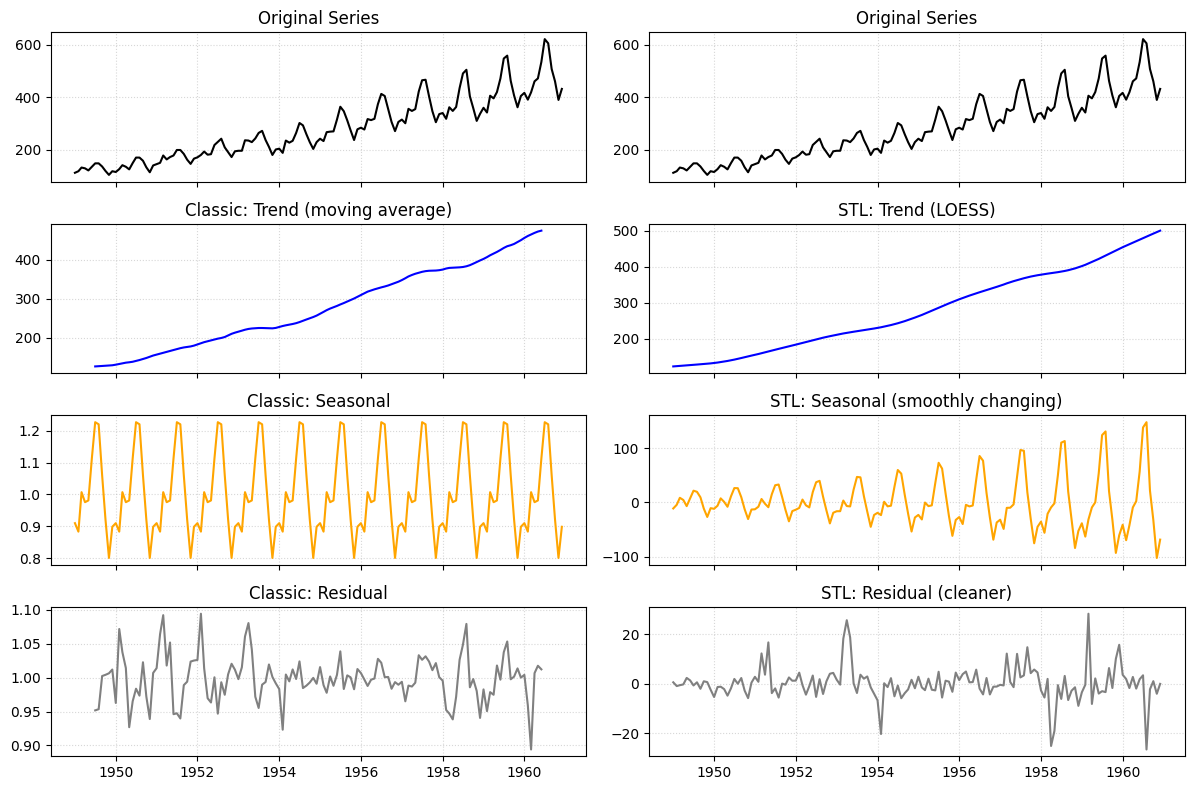

In [7]:
# ==============================
# STL vs Classical Decomposition
# ==============================

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, seasonal_decompose
import statsmodels.api as sm

# === Load dataset ===
# Monthly international airline passengers (1949–1960)
data = sm.datasets.get_rdataset("AirPassengers").data
# Some versions may store as 'value' not 'Passengers'
if "value" in data.columns:
    data.rename(columns={"value": "Passengers"}, inplace=True)

# Construct datetime index
data["Month"] = pd.date_range(start="1949-01-01", periods=len(data), freq="MS")
data.set_index("Month", inplace=True)
y = data["Passengers"]

# === Classical Decomposition (multiplicative) ===
classic = seasonal_decompose(y, model="multiplicative", period=12)

# === STL Decomposition ===
stl = STL(y, period=12, robust=True)
res_stl = stl.fit()

# === Plot comparison ===
fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=True)

# Original
axes[0,0].plot(y, color='black'); axes[0,0].set_title("Original Series")
axes[0,1].plot(y, color='black'); axes[0,1].set_title("Original Series")

# Trend
axes[1,0].plot(classic.trend, color='blue'); axes[1,0].set_title("Classic: Trend (moving average)")
axes[1,1].plot(res_stl.trend, color='blue'); axes[1,1].set_title("STL: Trend (LOESS)")

# Seasonal
axes[2,0].plot(classic.seasonal, color='orange'); axes[2,0].set_title("Classic: Seasonal")
axes[2,1].plot(res_stl.seasonal, color='orange'); axes[2,1].set_title("STL: Seasonal (smoothly changing)")

# Residual
axes[3,0].plot(classic.resid, color='gray'); axes[3,0].set_title("Classic: Residual")
axes[3,1].plot(res_stl.resid, color='gray'); axes[3,1].set_title("STL: Residual (cleaner)")

for ax in axes.flat:
    ax.grid(True, linestyle=":", alpha=0.5)

plt.tight_layout()
plt.show()


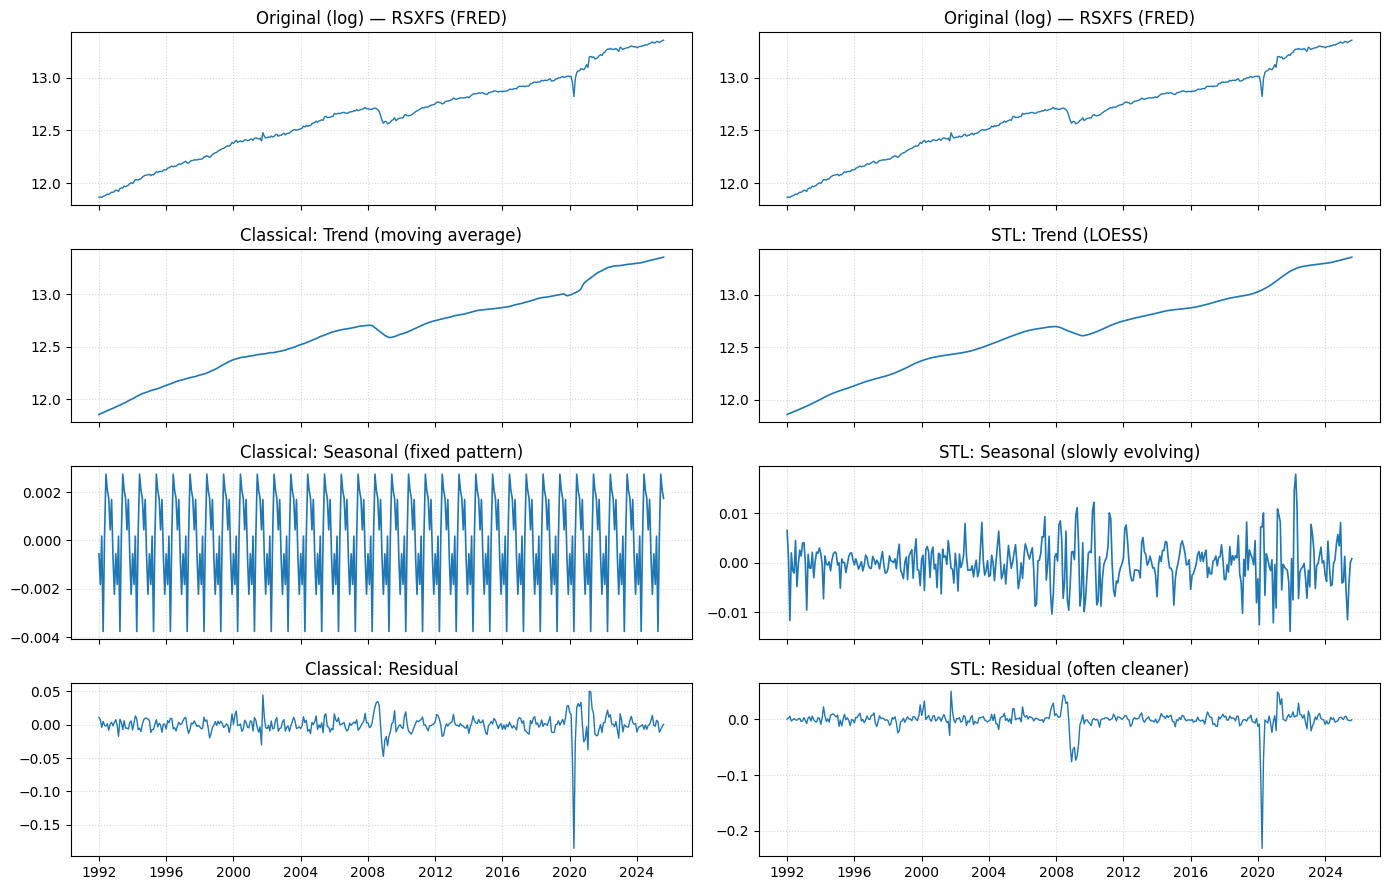

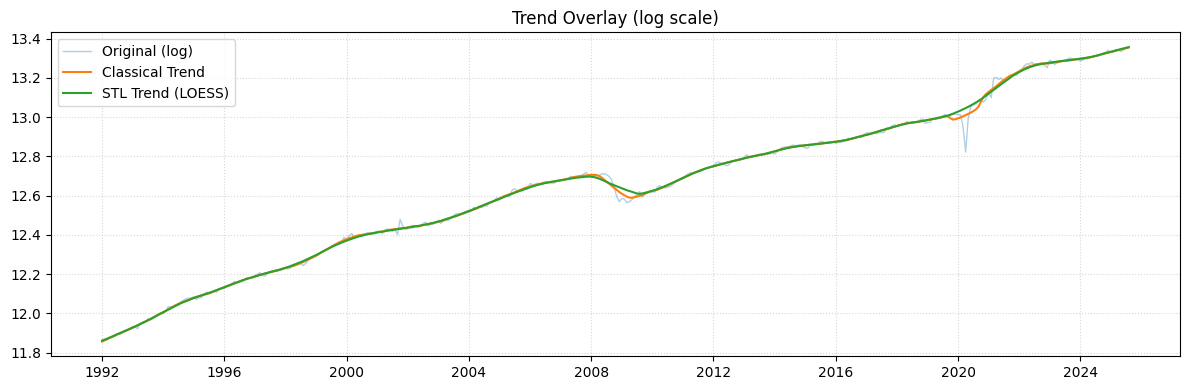

In [8]:
# stl_vs_classical_retail_fred.py
# Compare STL vs Classical decomposition on real monthly U.S. Retail Sales (FRED)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import STL, seasonal_decompose

# You may need: pip install pandas_datareader statsmodels matplotlib

def fetch_fred_monthly(series_candidates=("RSXFS", "RSAFS"), start="1992-01-01"):
    """
    Try multiple FRED series for Retail & Food Services:
      - RSXFS: Retail Sales and Food Services (Millions of $)
      - RSAFS: Advance Retail Sales: Retail and Food Services (Millions of $)
    Returns a monthly Series with Month Start ('MS') frequency.
    """
    from pandas_datareader import data as pdr

    last_err = None
    for code in series_candidates:
        try:
            s = pdr.DataReader(code, "fred", start=start)
            s = s.iloc[:, 0] if isinstance(s, pd.DataFrame) else s  # ensure Series
            s = s.asfreq("D").resample("MS").last()  # monthly start
            s.name = code
            return s.dropna()
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to fetch any of {series_candidates}. Last error: {last_err}")

def main():
    # 1) Load real monthly data from FRED
    y = fetch_fred_monthly(start="1992-01-01")  # returns a pd.Series (monthly)

    # Optional: use log scale to stabilize variance (often helps classical additive)
    y_log = (y.apply(float)).pipe(pd.Series)  # ensure float, Series
    y_log = y_log.apply(lambda v: float(v))
    y_log = pd.Series(np.log(y_log.values), index=y_log.index, name=y.name)  # log(y)

    period = 12  # monthly seasonality

    # 2) Classical decomposition
    # Use additive on log-transformed data (equivalent to multiplicative on original)
    classic = seasonal_decompose(y_log, model="additive", period=period, extrapolate_trend="freq")

    # 3) STL decomposition (robust LOESS)
    stl = STL(y_log, period=period, robust=True)
    res_stl = stl.fit()

    # 4) Plot: side-by-side comparison
    fig, axes = plt.subplots(4, 2, figsize=(14, 9), sharex=True)

    # Original (log)
    axes[0, 0].plot(y_log, linewidth=1)
    axes[0, 0].set_title(f"Original (log) — {y.name} (FRED)")
    axes[0, 1].plot(y_log, linewidth=1)
    axes[0, 1].set_title(f"Original (log) — {y.name} (FRED)")

    # Trend
    axes[1, 0].plot(classic.trend, linewidth=1.2)
    axes[1, 0].set_title("Classical: Trend (moving average)")
    axes[1, 1].plot(res_stl.trend, linewidth=1.2)
    axes[1, 1].set_title("STL: Trend (LOESS)")

    # Seasonal
    axes[2, 0].plot(classic.seasonal, linewidth=1.2)
    axes[2, 0].set_title("Classical: Seasonal (fixed pattern)")
    axes[2, 1].plot(res_stl.seasonal, linewidth=1.2)
    axes[2, 1].set_title("STL: Seasonal (slowly evolving)")

    # Residuals
    axes[3, 0].plot(classic.resid, linewidth=1)
    axes[3, 0].set_title("Classical: Residual")
    axes[3, 1].plot(res_stl.resid, linewidth=1)
    axes[3, 1].set_title("STL: Residual (often cleaner)")

    for ax in axes.flat:
        ax.grid(True, linestyle=":", alpha=0.5)

    plt.tight_layout()
    plt.show()

    # 5) Optional overlay to see trend differences directly
    fig2, ax2 = plt.subplots(figsize=(12, 4))
    ax2.plot(y_log, alpha=0.35, linewidth=1, label="Original (log)")
    ax2.plot(classic.trend, linewidth=1.5, label="Classical Trend")
    ax2.plot(res_stl.trend, linewidth=1.5, label="STL Trend (LOESS)")
    ax2.set_title("Trend Overlay (log scale)")
    ax2.grid(True, linestyle=":", alpha=0.5)
    ax2.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


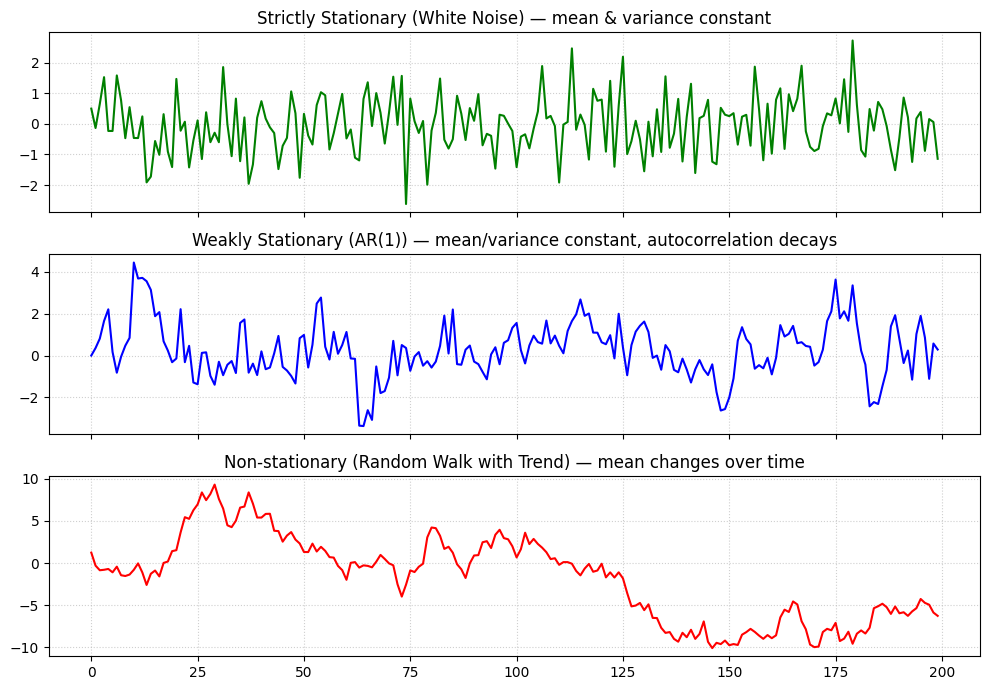

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

n = 200

# ----------------------------
# 1. Strictly stationary series
# ----------------------------
# White noise: same distribution, same mean/variance all the time
strict_stationary = np.random.normal(0, 1, n)

# ----------------------------
# 2. Weakly stationary series
# ----------------------------
# AR(1): mean & variance constant, correlations decay but stable
phi = 0.7
weak_stationary = np.zeros(n)
for t in range(1, n):
    weak_stationary[t] = phi * weak_stationary[t-1] + np.random.normal(0, 1)

# ----------------------------
# 3. Non-stationary series
# ----------------------------
# Mean increases over time (trend)
non_stationary = np.cumsum(np.random.normal(0, 1, n)) + np.linspace(0, 10, n)

# ----------------------------
# Plot comparison
# ----------------------------
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(strict_stationary, color="green")
axes[0].set_title("Strictly Stationary (White Noise) — mean & variance constant")

axes[1].plot(weak_stationary, color="blue")
axes[1].set_title("Weakly Stationary (AR(1)) — mean/variance constant, autocorrelation decays")

axes[2].plot(non_stationary, color="red")
axes[2].set_title("Non-stationary (Random Walk with Trend) — mean changes over time")

for ax in axes:
    ax.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.show()


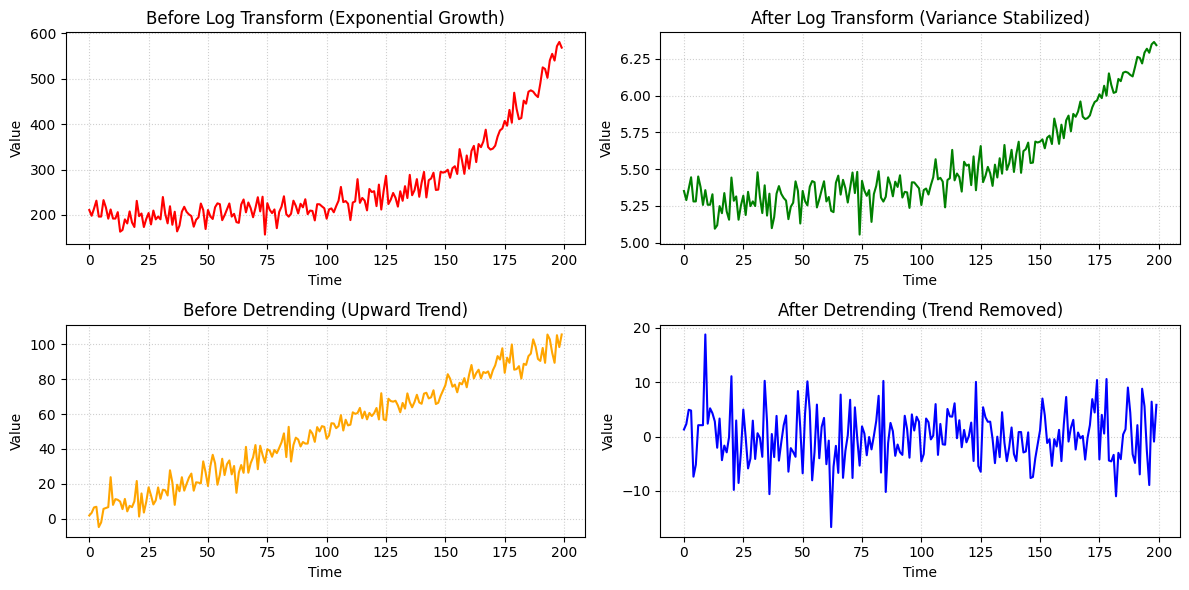

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

np.random.seed(42)
n = 200
t = np.arange(n)

# ---------------------------------
# 1️⃣ Non-stationary exponential growth (for log transform demo)
# ---------------------------------
trend_exp = 200+np.exp(0.03 * t) + np.random.normal(0, 20, n)
log_transformed = np.log(trend_exp)

# ---------------------------------
# 2️⃣ Linear trend (for detrending demo)
# ---------------------------------
trend_linear = 0.5 * t + np.random.normal(0, 5, n)
detrended = signal.detrend(trend_linear)

# ---------------------------------
# Plot: Log transform vs Detrending
# ---------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Original exponential vs log-transformed
axes[0, 0].plot(t, trend_exp, color="red")
axes[0, 0].set_title("Before Log Transform (Exponential Growth)")
axes[0, 1].plot(t, log_transformed, color="green")
axes[0, 1].set_title("After Log Transform (Variance Stabilized)")

# Original trend vs detrended
axes[1, 0].plot(t, trend_linear, color="orange")
axes[1, 0].set_title("Before Detrending (Upward Trend)")
axes[1, 1].plot(t, detrended, color="blue")
axes[1, 1].set_title("After Detrending (Trend Removed)")

for ax in axes.flat:
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()


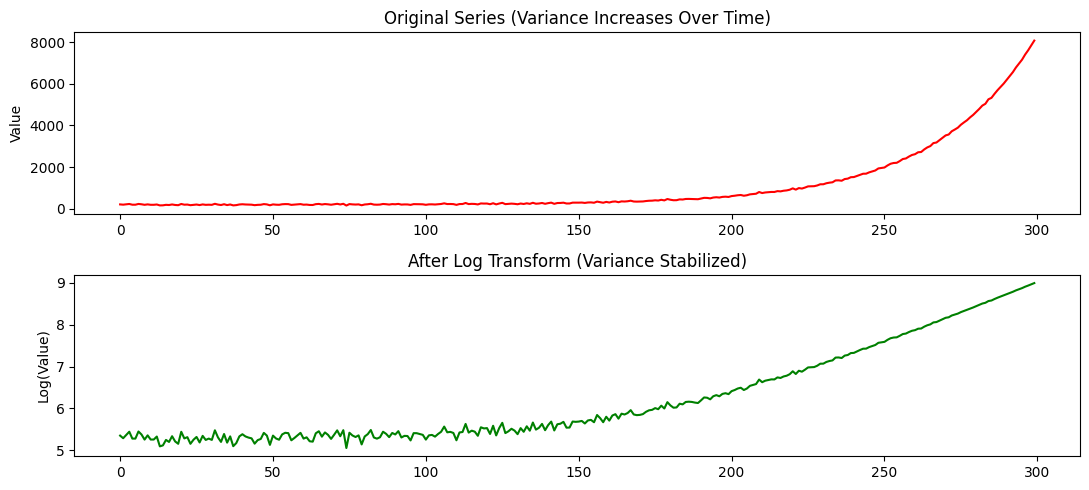

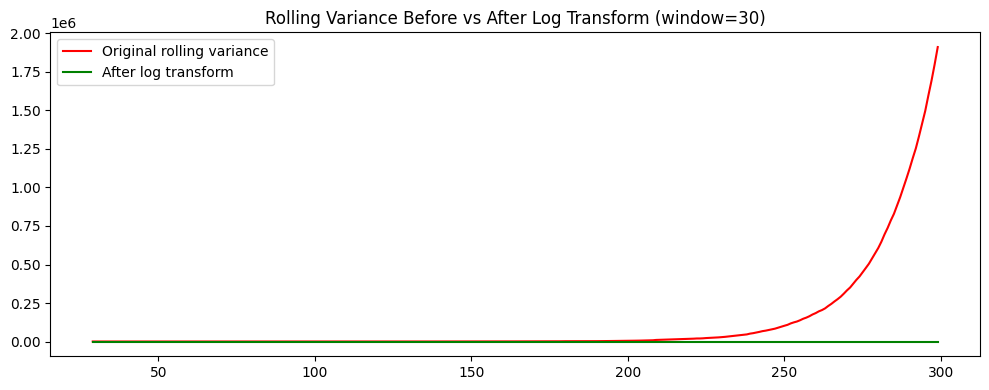

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n = 300
t = np.arange(n)

# Exponentially growing data (non-stationary variance)
y = 200+np.exp(0.03 * t) + np.random.normal(0, 20, n)
y_log = np.log(y)

# Rolling variance (window=30)
roll_var_orig = pd.Series(y).rolling(30).var()
roll_var_log = pd.Series(y_log).rolling(30).var()

plt.figure(figsize=(11,5))
plt.subplot(2,1,1)
plt.plot(y, color='red')
plt.title("Original Series (Variance Increases Over Time)")
plt.ylabel("Value")

plt.subplot(2,1,2)
plt.plot(y_log, color='green')
plt.title("After Log Transform (Variance Stabilized)")
plt.ylabel("Log(Value)")
plt.tight_layout()
plt.show()

# Compare rolling variance
plt.figure(figsize=(10,4))
plt.plot(roll_var_orig, color='red', label='Original rolling variance')
plt.plot(roll_var_log, color='green', label='After log transform')
plt.title("Rolling Variance Before vs After Log Transform (window=30)")
plt.legend()
plt.tight_layout()
plt.show()


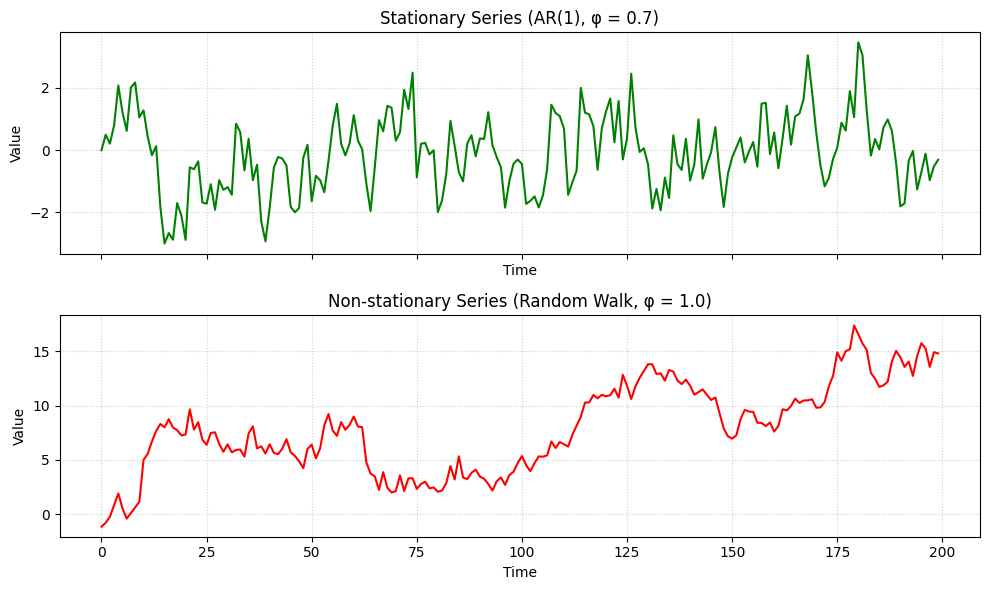


=== ADF Test: Stationary AR(1) ===
ADF Statistic: -6.468
p-value: 0.000
Critical Value (1%): -3.464
Critical Value (5%): -2.876
Critical Value (10%): -2.575
→ Reject H₀: Series is STATIONARY ✅

=== ADF Test: Non-stationary Random Walk ===
ADF Statistic: -2.006
p-value: 0.284
Critical Value (1%): -3.464
Critical Value (5%): -2.876
Critical Value (10%): -2.575
→ Fail to reject H₀: Series is NON-STATIONARY ❌


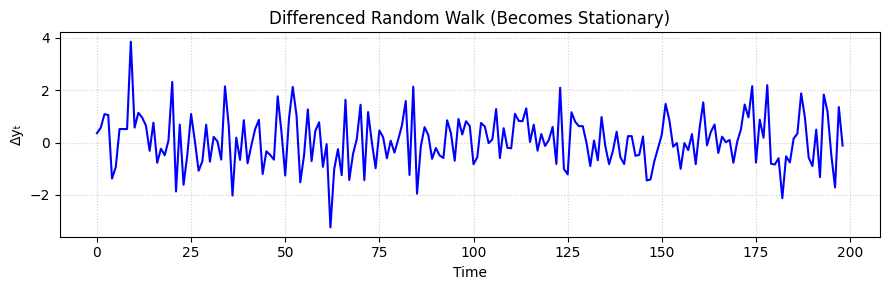


=== ADF Test: Differenced Random Walk ===
ADF Statistic: -14.714
p-value: 0.000
Critical Value (1%): -3.464
Critical Value (5%): -2.876
Critical Value (10%): -2.575
→ Reject H₀: Series is STATIONARY ✅


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

np.random.seed(42)
n = 200

# ----------------------------
# 1️⃣ Stationary series (AR(1) with |phi| < 1)
# ----------------------------
phi = 0.7
stationary = np.zeros(n)
for t in range(1, n):
    stationary[t] = phi * stationary[t-1] + np.random.normal(0, 1)

# ----------------------------
# 2️⃣ Non-stationary series (unit root / random walk)
# ----------------------------
non_stationary = np.cumsum(np.random.normal(0, 1, n))  # random walk

# ----------------------------
# 3️⃣ Plot both series
# ----------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(stationary, color="green")
axes[0].set_title("Stationary Series (AR(1), φ = 0.7)")
axes[1].plot(non_stationary, color="red")
axes[1].set_title("Non-stationary Series (Random Walk, φ = 1.0)")

for ax in axes:
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()

# ----------------------------
# 4️⃣ ADF test function
# ----------------------------
def adf_summary(series, name):
    result = adfuller(series)
    print(f"\n=== ADF Test: {name} ===")
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.3f}")
    if result[1] < 0.05:
        print("→ Reject H₀: Series is STATIONARY ✅")
    else:
        print("→ Fail to reject H₀: Series is NON-STATIONARY ❌")

# ----------------------------
# 5️⃣ Run ADF on both
# ----------------------------
adf_summary(stationary, "Stationary AR(1)")
adf_summary(non_stationary, "Non-stationary Random Walk")

# ----------------------------
# 6️⃣ Optional: Differencing non-stationary series
# ----------------------------
diff_series = np.diff(non_stationary)

plt.figure(figsize=(9, 3))
plt.plot(diff_series, color="blue")
plt.title("Differenced Random Walk (Becomes Stationary)")
plt.xlabel("Time")
plt.ylabel("Δyₜ")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

adf_summary(diff_series, "Differenced Random Walk")


In [13]:
def kpss_summary(series, name):
    statistic, p_value, _, crit = kpss(series, regression='c', nlags='auto')
    print(f"\n=== KPSS Test: {name} ===")
    print(f"KPSS Statistic: {statistic:.3f}")
    print(f"p-value: {p_value:.3f}")
    for key, value in crit.items():
        print(f"Critical Value ({key}): {value:.3f}")
    if p_value < 0.05:
        print("→ Reject H₀: Series is NON-STATIONARY ❌")
    else:
        print("→ Fail to reject H₀: Series is STATIONARY ✅")

kpss_summary(stationary, "Stationary AR(1)")
kpss_summary(non_stationary, "Non-stationary Random Walk")


=== KPSS Test: Stationary AR(1) ===
KPSS Statistic: 0.330
p-value: 0.100
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739
→ Fail to reject H₀: Series is STATIONARY ✅

=== KPSS Test: Non-stationary Random Walk ===
KPSS Statistic: 1.305
p-value: 0.010
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739
→ Reject H₀: Series is NON-STATIONARY ❌


In [14]:
from arch.unitroot import PhillipsPerron
def pp_summary(series, name):
    result = PhillipsPerron(series)
    pval = result.pvalue
    stat = result.stat
    print(f"\n=== Phillips–Perron Test: {name} ===")
    print(f"Test Statistic: {stat:.3f}")
    print(f"p-value: {pval:.4f}")
    print(f"Null Hypothesis: Series has a UNIT ROOT (non-stationary)")
    
    if pval < 0.05:
        print("→ Reject H₀: Series is STATIONARY ✅")
    else:
        print("→ Fail to reject H₀: Series is NON-STATIONARY ❌")

# ----------------------------
# 4️⃣ Run PP tests
# ----------------------------
pp_summary(stationary, "Stationary AR(1)")
pp_summary(non_stationary, "Non-stationary Random Walk")


=== Phillips–Perron Test: Stationary AR(1) ===
Test Statistic: -6.601
p-value: 0.0000
Null Hypothesis: Series has a UNIT ROOT (non-stationary)
→ Reject H₀: Series is STATIONARY ✅

=== Phillips–Perron Test: Non-stationary Random Walk ===
Test Statistic: -2.056
p-value: 0.2627
Null Hypothesis: Series has a UNIT ROOT (non-stationary)
→ Fail to reject H₀: Series is NON-STATIONARY ❌


                         MAE   RMSE  MAPE (%)
Naïve                  13.00  15.52      9.38
Seasonal-Naïve (m=12)   9.31  11.36      6.84
Drift                   8.89  10.79      6.44


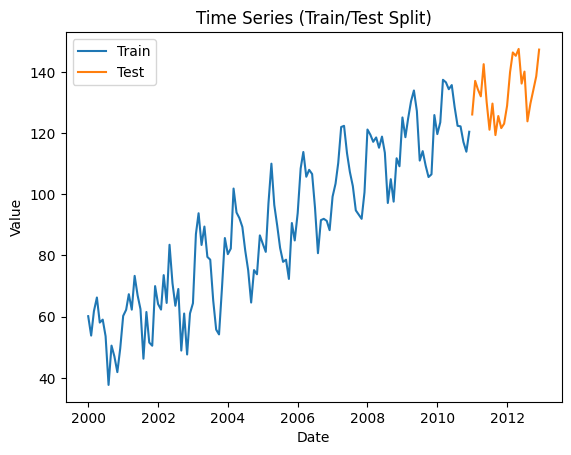

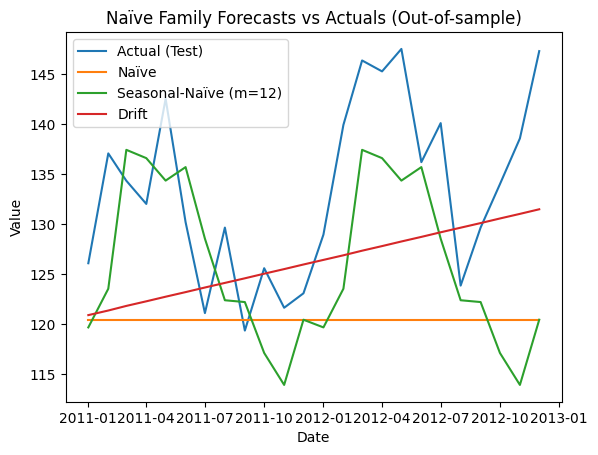

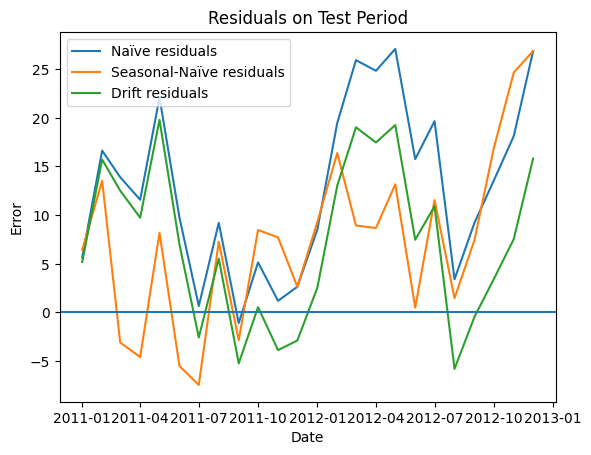

In [15]:
# Naïve time-series forecasting demo
# pip install matplotlib pandas numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# 1) Create a synthetic monthly series (trend + seasonality + noise)
rng = pd.date_range(start="2000-01-01", end="2012-12-01", freq="MS")  # monthly start
n = len(rng)

np.random.seed(7)
trend = 0.6 * np.arange(n)
seasonal = 12 * np.sin(2 * np.pi * (np.arange(n) % 12) / 12.0)
noise = np.random.normal(0, 6, size=n)
y = 50 + trend + seasonal + noise

ts = pd.Series(y, index=rng, name="y")

# Train/test split
h = 24  # forecast horizon
train = ts.iloc[:-h]
test = ts.iloc[-h:]

# 2) Forecasting helpers
def naive_forecast(series: pd.Series, h: int) -> pd.Series:
    """Naïve (last observation carried forward)."""
    last = series.iloc[-1]
    idx = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(), periods=h, freq="MS")
    return pd.Series(np.repeat(last, h), index=idx, name="naive")

def seasonal_naive_forecast(series: pd.Series, h: int, m: int = 12) -> pd.Series:
    """Seasonal naïve (repeat last observed season)."""
    last_season = series.iloc[-m:]
    reps = int(np.ceil(h / m))
    vals = np.tile(last_season.values, reps)[:h]
    idx = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(), periods=h, freq="MS")
    return pd.Series(vals, index=idx, name=f"snaive_m{m}")

def drift_forecast(series: pd.Series, h: int) -> pd.Series:
    """Drift method (random walk with drift)."""
    y1 = series.iloc[0]
    yT = series.iloc[-1]
    T = len(series) - 1
    slope = (yT - y1) / T if T > 0 else 0.0
    idx = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(), periods=h, freq="MS")
    steps = np.arange(1, h + 1)
    vals = yT + slope * steps
    return pd.Series(vals, index=idx, name="drift")

# Generate forecasts
f_naive = naive_forecast(train, h)
f_snaive = seasonal_naive_forecast(train, h, m=12)
f_drift = drift_forecast(train, h)

# 3) Accuracy metrics
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

metrics = pd.DataFrame({
    "MAE":  [mae(test.values, f_naive.values),
             mae(test.values, f_snaive.values),
             mae(test.values, f_drift.values)],
    "RMSE": [rmse(test.values, f_naive.values),
             rmse(test.values, f_snaive.values),
             rmse(test.values, f_drift.values)],
    "MAPE (%)": [mape(test.values, f_naive.values),
                 mape(test.values, f_snaive.values),
                 mape(test.values, f_drift.values)]
}, index=["Naïve", "Seasonal-Naïve (m=12)", "Drift"]).round(2)

print(metrics)

# 4) Plots (matplotlib)
# (A) Full series with train/test split
plt.figure()
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test")
plt.title("Time Series (Train/Test Split)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# (B) Test vs forecasts
plt.figure()
plt.plot(test.index, test.values, label="Actual (Test)")
plt.plot(f_naive.index, f_naive.values, label="Naïve")
plt.plot(f_snaive.index, f_snaive.values, label="Seasonal-Naïve (m=12)")
plt.plot(f_drift.index, f_drift.values, label="Drift")
plt.title("Naïve Family Forecasts vs Actuals (Out-of-sample)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# (C) Residuals on test period
res_naive = test - f_naive
res_snaive = test - f_snaive
res_drift = test - f_drift

plt.figure()
plt.plot(res_naive.index, res_naive.values, label="Naïve residuals")
plt.plot(res_snaive.index, res_snaive.values, label="Seasonal-Naïve residuals")
plt.plot(res_drift.index, res_drift.values, label="Drift residuals")
plt.axhline(0)
plt.title("Residuals on Test Period")
plt.xlabel("Date")
plt.ylabel("Error")
plt.legend()
plt.show()


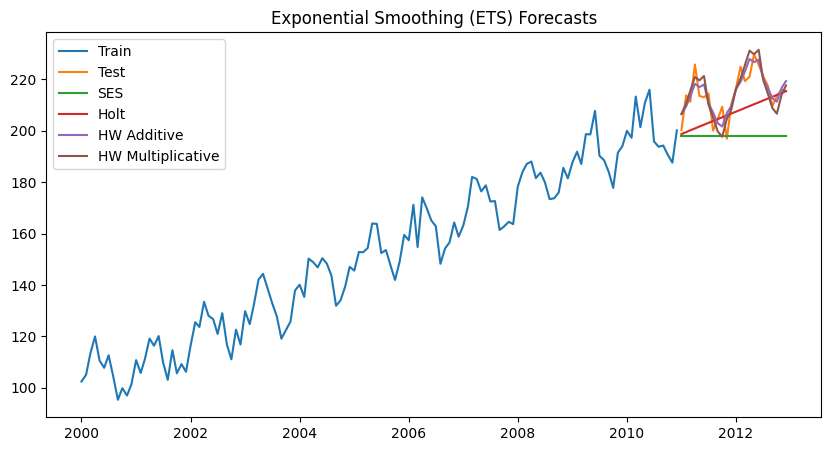

          MAE   RMSE  MAPE (%)
SES     16.43  18.29      7.53
Holt     8.67  10.77      3.98
HW-Add   3.86   4.66      1.82
HW-Mul   4.67   5.51      2.19


In [16]:
# Exponential Smoothing (ETS) example
# pip install statsmodels matplotlib pandas numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 1) Create synthetic monthly data with trend + seasonality
rng = pd.date_range("2000-01-01", periods=156, freq="MS")
np.random.seed(42)
y = 100 + 0.8 * np.arange(156) + 10 * np.sin(2 * np.pi * np.arange(156)/12) + np.random.normal(0, 5, 156)
ts = pd.Series(y, index=rng)

# Split train/test
train, test = ts[:-24], ts[-24:]

# 2) Fit ETS models
ses = SimpleExpSmoothing(train).fit(optimized=True)
holt = ExponentialSmoothing(train, trend="add").fit(optimized=True)
hw_add = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).fit(optimized=True)
hw_mul = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12).fit(optimized=True)

# Forecast
ses_f = ses.forecast(24)
holt_f = holt.forecast(24)
hw_add_f = hw_add.forecast(24)
hw_mul_f = hw_mul.forecast(24)

# 3) Plot
plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(ses_f, label="SES")
plt.plot(holt_f, label="Holt")
plt.plot(hw_add_f, label="HW Additive")
plt.plot(hw_mul_f, label="HW Multiplicative")
plt.title("Exponential Smoothing (ETS) Forecasts")
plt.legend()
plt.show()

# 4) Compare performance
def rmse(y, yhat): return np.sqrt(((y - yhat)**2).mean())
def mae(y, yhat): return np.abs(y - yhat).mean()
def mape(y, yhat): return (np.abs((y - yhat)/y).mean()) * 100

metrics = pd.DataFrame({
    "MAE": [mae(test, ses_f), mae(test, holt_f), mae(test, hw_add_f), mae(test, hw_mul_f)],
    "RMSE": [rmse(test, ses_f), rmse(test, holt_f), rmse(test, hw_add_f), rmse(test, hw_mul_f)],
    "MAPE (%)": [mape(test, ses_f), mape(test, holt_f), mape(test, hw_add_f), mape(test, hw_mul_f)]
}, index=["SES", "Holt", "HW-Add", "HW-Mul"])

print(metrics.round(2))


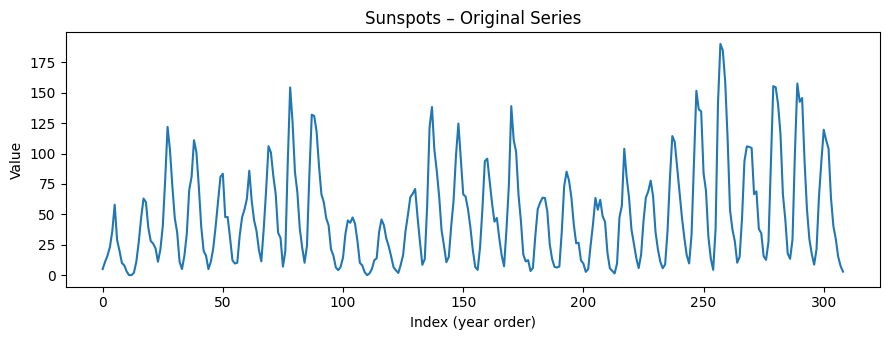

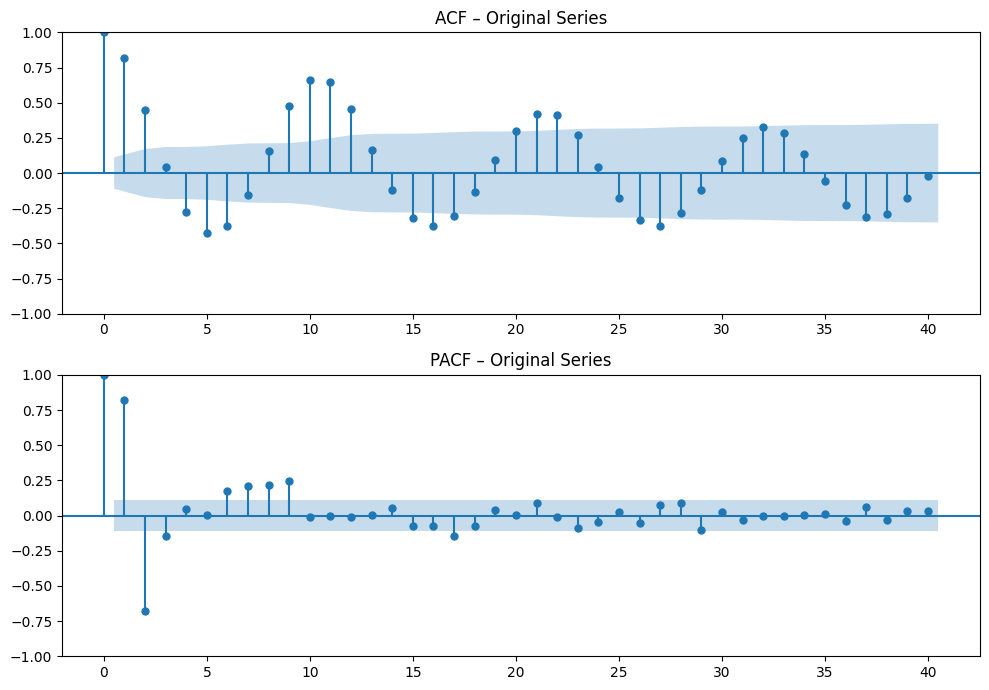

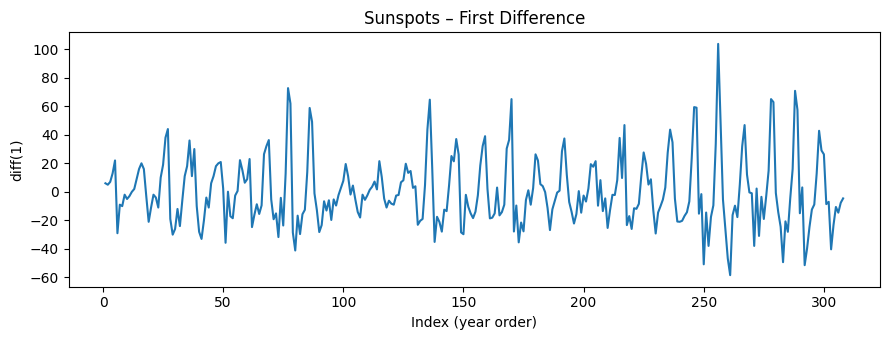

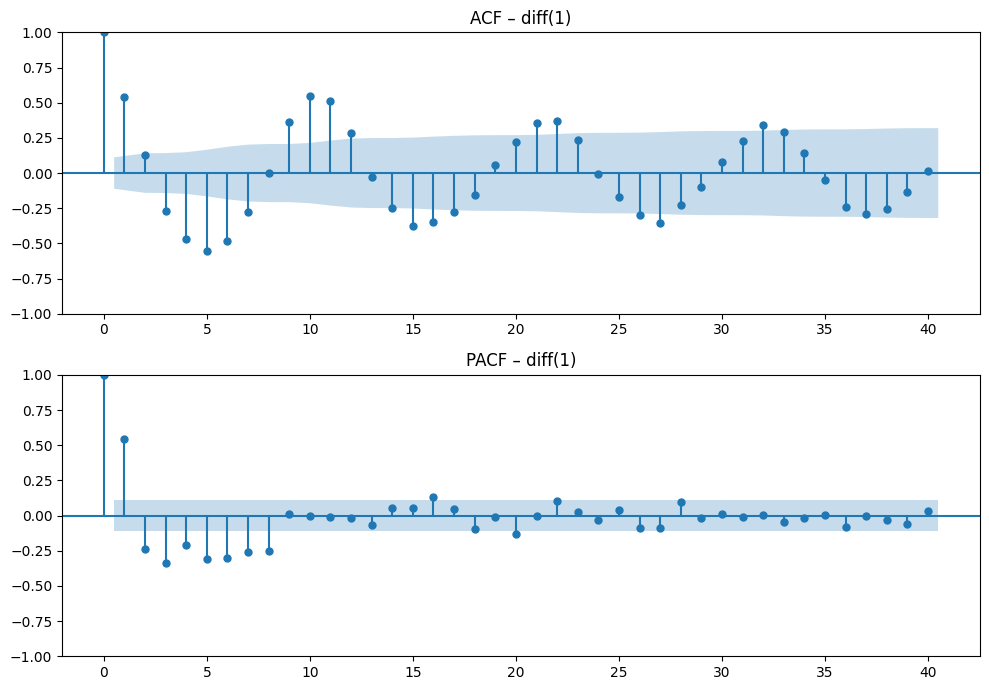

ADF (original): {'series': 'original', 'adf_stat': np.float64(-2.8377807249381988), 'p_value': np.float64(0.05307642172812007), 'lags_used': 8, 'nobs': 300}
ADF (diff1):    {'series': 'diff(1)', 'adf_stat': np.float64(-14.861663428129392), 'p_value': np.float64(1.715552423167096e-27), 'lags_used': 7, 'nobs': 300}
Approx 95% CI for ACF/PACF significance: ±0.112
Heuristic AR order p (from PACF cutoff): 9
Heuristic MA order q (from ACF cutoff):  None
Fitted ARIMA(9,1,1) – AIC: 2568.21


In [17]:
# Re-running the ACF/PACF demo (session reset).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.datasets import sunspots
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load real dataset (bundled): annual sunspot numbers
data = sunspots.load_pandas().data
y = pd.Series(data["SUNACTIVITY"].values, index=pd.RangeIndex(len(data)), name="sunspots")

def adf_report(series, name):
    res = adfuller(series, autolag="AIC")
    return {"series": name, "adf_stat": res[0], "p_value": res[1], "lags_used": res[2], "nobs": res[3]}

adf_orig = adf_report(y, "original")

# First difference to help stationarity
dy = y.diff().dropna()
adf_diff = adf_report(dy, "diff(1)")

# Plot: original
plt.figure(figsize=(9, 3.5))
plt.plot(y.index, y.values)
plt.title("Sunspots – Original Series")
plt.xlabel("Index (year order)")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(2,1,1)
plot_acf(y, ax=ax1, lags=40)
ax1.set_title("ACF – Original Series")
ax2 = fig.add_subplot(2,1,2)
plot_pacf(y, ax=ax2, lags=40, method="ywm")
ax2.set_title("PACF – Original Series")
plt.tight_layout()
plt.show()

# Plot: differenced
plt.figure(figsize=(9, 3.5))
plt.plot(dy.index, dy.values)
plt.title("Sunspots – First Difference")
plt.xlabel("Index (year order)")
plt.ylabel("diff(1)")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(2,1,1)
plot_acf(dy, ax=ax1, lags=40)
ax1.set_title("ACF – diff(1)")
ax2 = fig.add_subplot(2,1,2)
plot_pacf(dy, ax=ax2, lags=40, method="ywm")
ax2.set_title("PACF – diff(1)")
plt.tight_layout()
plt.show()

# Heuristic p/q detection on differenced series
N = len(dy)
ci = 1.96 / np.sqrt(N)
pacf_vals = pacf(dy, nlags=20, method="ywm")
acf_vals = acf(dy, nlags=20, fft=True)

def first_cutoff(vals, ci):
    for k in range(1, len(vals)):
        if abs(vals[k]) < ci:
            tail_small = all(abs(v) < ci for v in vals[k:min(len(vals), k+3)])
            if tail_small:
                return k
    return None

p_guess = first_cutoff(pacf_vals, ci)  # AR order
q_guess = first_cutoff(acf_vals, ci)   # MA order

print("ADF (original):", adf_orig)
print("ADF (diff1):   ", adf_diff)
print(f"Approx 95% CI for ACF/PACF significance: ±{ci:.3f}")
print("Heuristic AR order p (from PACF cutoff):", p_guess)
print("Heuristic MA order q (from ACF cutoff): ", q_guess)

# Optional: quick ARIMA fit using guesses
try:
    from statsmodels.tsa.arima.model import ARIMA
    p = p_guess or 1
    d = 1
    q = q_guess or 1
    res = ARIMA(y, order=(p, d, q)).fit()
    print(f"Fitted ARIMA({p},{d},{q}) – AIC: {res.aic:.2f}")
except Exception as e:
    print("ARIMA fit skipped:", e)


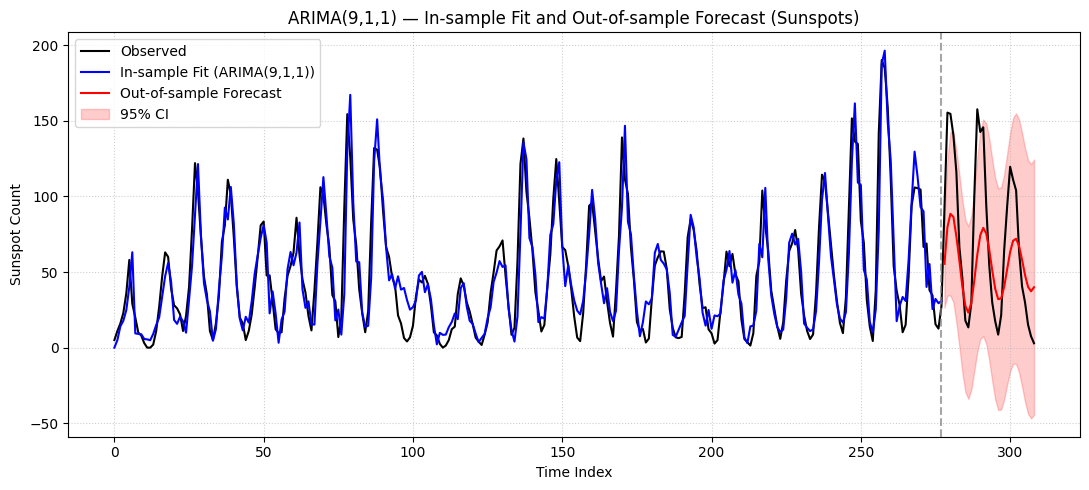

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import sunspots
from statsmodels.tsa.arima.model import ARIMA

# -----------------------------
# 1) Load data
# -----------------------------
data = sunspots.load_pandas().data
y = pd.Series(data["SUNACTIVITY"].values, index=pd.RangeIndex(len(data)), name="sunspots")

# -----------------------------
# 2) Train / test split
# -----------------------------
train_size = int(len(y) * 0.9)   # 90% train, 10% test
train, test = y.iloc[:train_size], y.iloc[train_size:]

# -----------------------------
# 3) Fit ARIMA(9,1,1) on train
# -----------------------------
res = ARIMA(train, order=(9,1,1)).fit()

# -----------------------------
# 4) In-sample fitted + OOS forecast (in levels)
#    Use prediction helpers to keep indices aligned
# -----------------------------
# In-sample fitted (levels). Will contain NaNs for the first d points; we'll dropna when plotting.
ins_pred = res.get_prediction(start=train.index[0], end=train.index[-1])
ins_fitted = ins_pred.predicted_mean  # matches train index

# Out-of-sample forecast with 95% CI
steps = len(test)
oos_fc = res.get_forecast(steps=steps)
oos_mean = oos_fc.predicted_mean           # index continues past train
oos_ci   = oos_fc.conf_int(alpha=0.05)     # DataFrame with lower/upper

# -----------------------------
# 5) Plot: observed, in-sample fit, forecast + CI
# -----------------------------
plt.figure(figsize=(11, 5))
plt.plot(y.index, y.values, color="black", label="Observed")

# In-sample fit (drop initial NaNs due to differencing)
plt.plot(ins_fitted.dropna().index, ins_fitted.dropna().values,
         color="blue", label="In-sample Fit (ARIMA(9,1,1))")

# Forecast + CI
plt.plot(oos_mean.index, oos_mean.values, color="red", label="Out-of-sample Forecast")
plt.fill_between(oos_ci.index,
                 oos_ci.iloc[:, 0].values,  # lower
                 oos_ci.iloc[:, 1].values,  # upper
                 alpha=0.2, color="red", label="95% CI")

# Vertical line at split
plt.axvline(train.index[-1], color="gray", linestyle="--", alpha=0.7)

plt.title("ARIMA(9,1,1) — In-sample Fit and Out-of-sample Forecast (Sunspots)")
plt.xlabel("Time Index")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


In [19]:
# BIC value
res.bic

np.float64(2343.1045556505405)

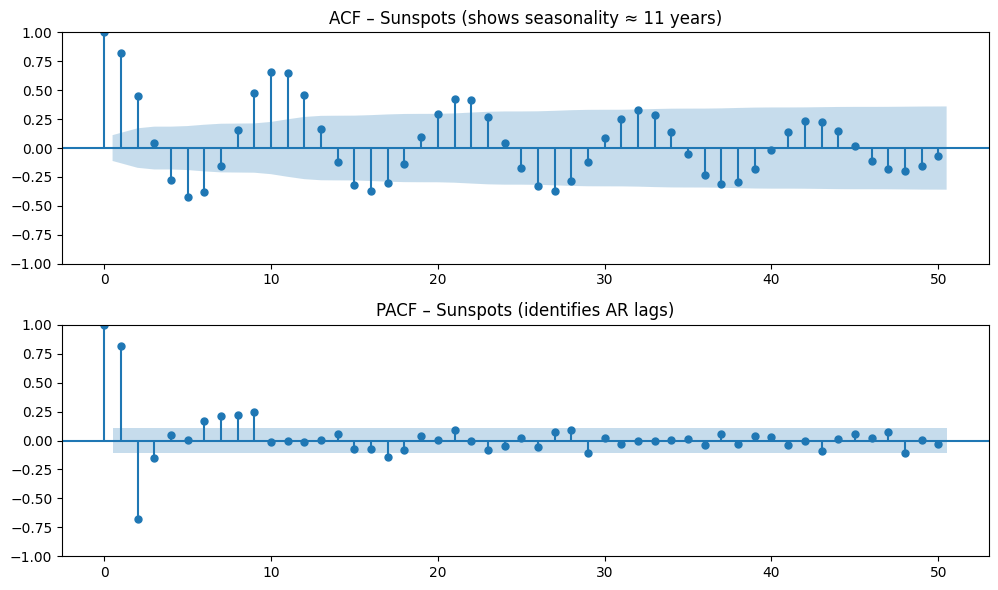

                                     SARIMAX Results                                      
Dep. Variable:                           sunspots   No. Observations:                  278
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 11)   Log Likelihood               -1066.636
Date:                            Sun, 12 Oct 2025   AIC                           2145.271
Time:                                    22:08:41   BIC                           2166.471
Sample:                                         0   HQIC                          2153.801
                                            - 278                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2636      0.046     27.658      0.000       1.174       1.353
ar.L2         -0.6190      0.043   

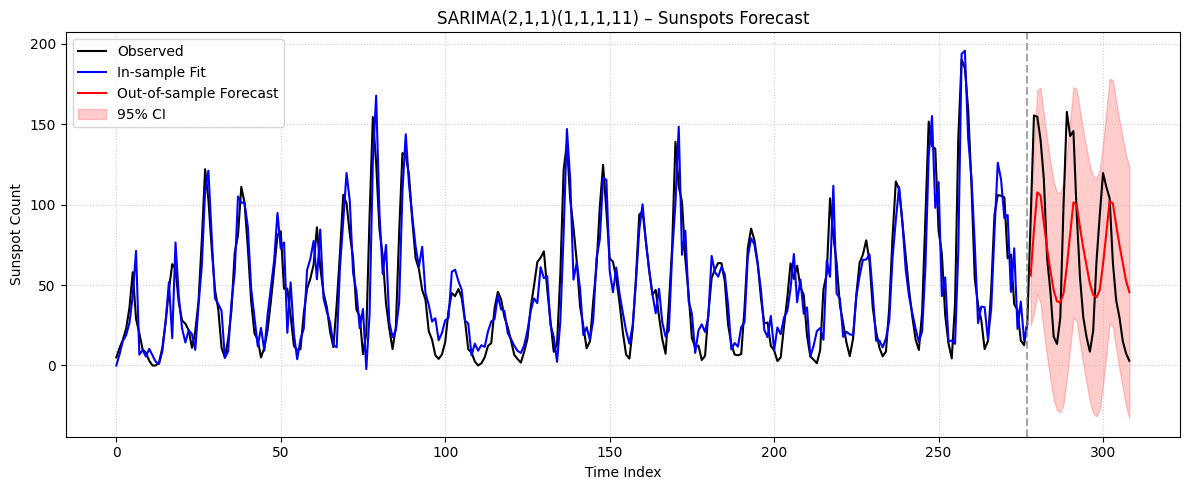

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import sunspots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# -----------------------------
# 1. Load data
# -----------------------------
data = sunspots.load_pandas().data
y = pd.Series(data["SUNACTIVITY"].values, index=pd.RangeIndex(len(data)), name="sunspots")

# -----------------------------
# 2. Check ACF/PACF for seasonality
# -----------------------------
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(y, lags=50, ax=ax[0])
plot_pacf(y, lags=50, ax=ax[1])
ax[0].set_title("ACF – Sunspots (shows seasonality ≈ 11 years)")
ax[1].set_title("PACF – Sunspots (identifies AR lags)")
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Split Train / Test
# -----------------------------
train_size = int(len(y) * 0.9)
train, test = y[:train_size], y[train_size:]

# -----------------------------
# 4. Fit SARIMA(p,d,q)(P,D,Q,s)
# -----------------------------
order = (2, 1, 1)         # ARIMA part
seasonal_order = (1, 1, 1, 11)  # seasonal part

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

print(res.summary())

# -----------------------------
# 5. In-sample and out-of-sample forecast
# -----------------------------
ins_pred = res.get_prediction(start=train.index[0], end=train.index[-1])
ins_fit = ins_pred.predicted_mean

steps = len(test)
oos_fc = res.get_forecast(steps=steps)
oos_mean = oos_fc.predicted_mean
oos_ci = oos_fc.conf_int(alpha=0.05)

# -----------------------------
# 6. Plot
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(y, color="black", label="Observed")
plt.plot(ins_fit.index, ins_fit.values, color="blue", label="In-sample Fit")
plt.plot(oos_mean.index, oos_mean.values, color="red", label="Out-of-sample Forecast")
plt.fill_between(oos_ci.index,
                 oos_ci.iloc[:, 0].values,
                 oos_ci.iloc[:, 1].values,
                 color="red", alpha=0.2, label="95% CI")

plt.axvline(train.index[-1], color="gray", linestyle="--", alpha=0.7)
plt.title("SARIMA(2,1,1)(1,1,1,11) – Sunspots Forecast")
plt.xlabel("Time Index")
plt.ylabel("Sunspot Count")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


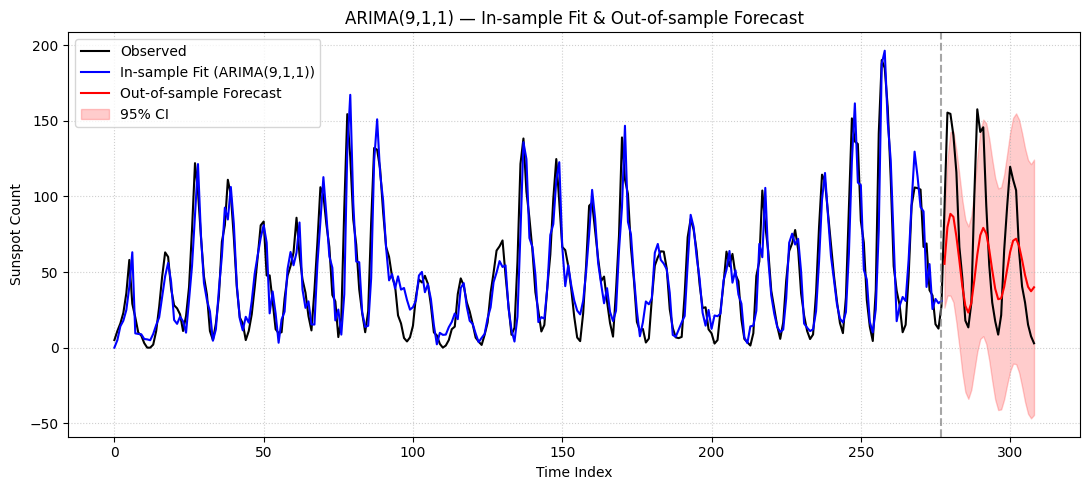

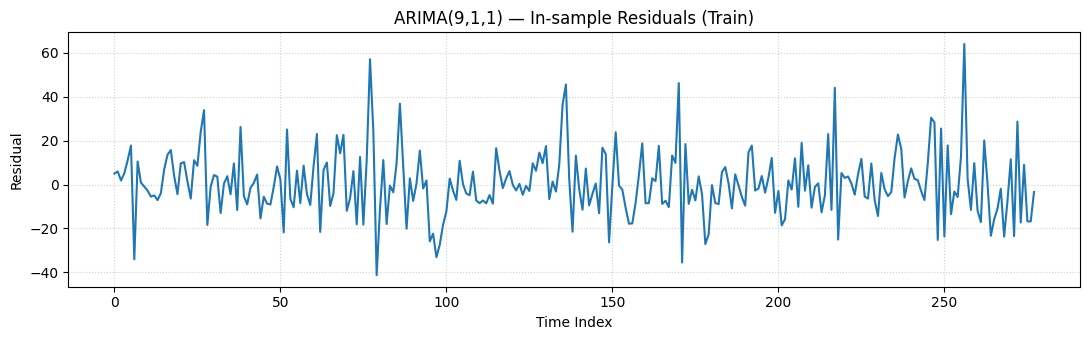

<Figure size 800x400 with 0 Axes>

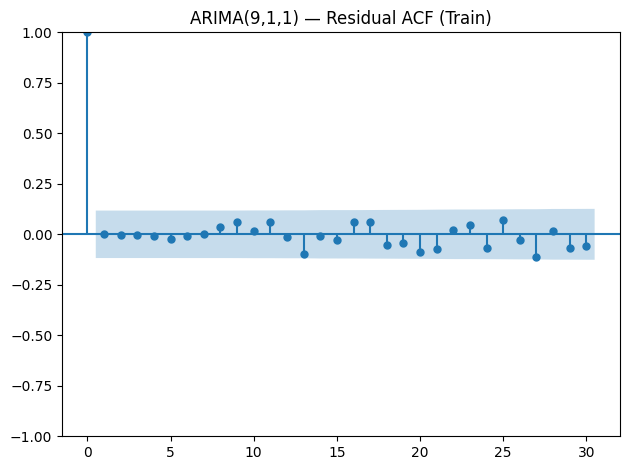

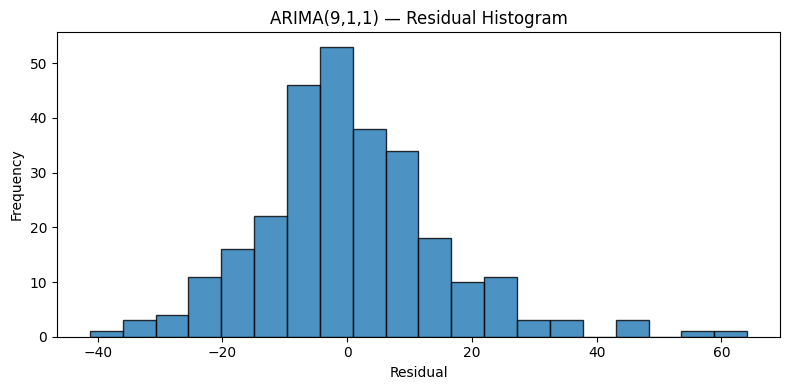

ARIMA(9,1,1) AIC (train): 2303.24


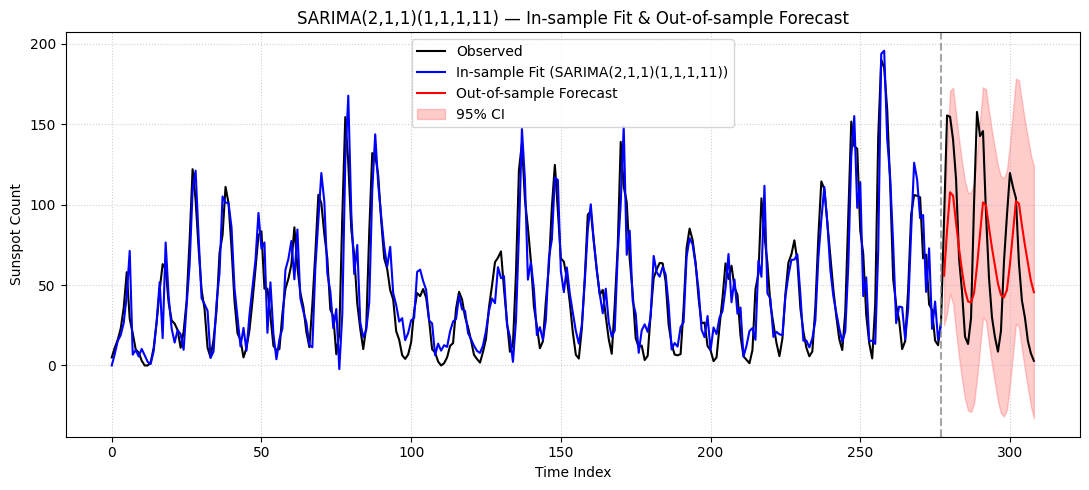

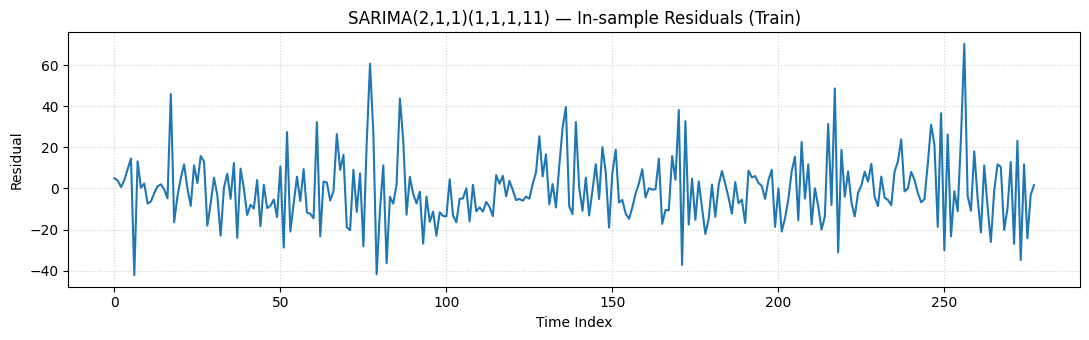

<Figure size 800x400 with 0 Axes>

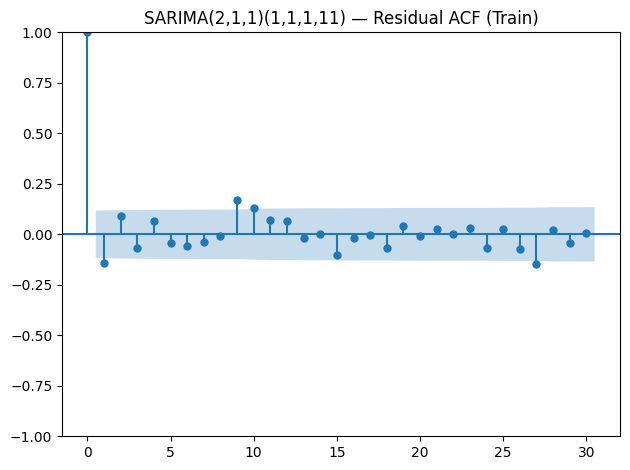

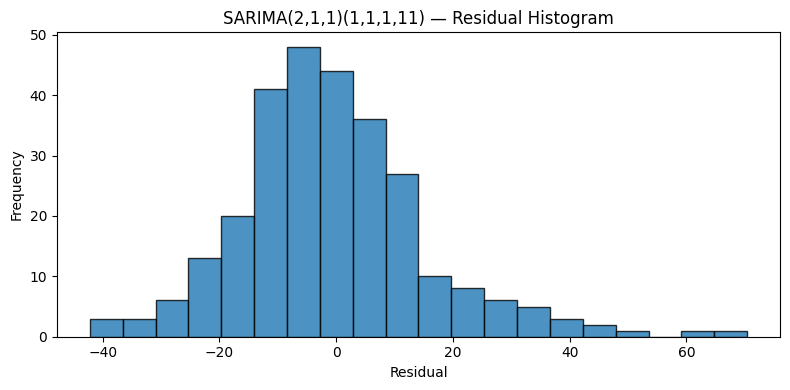

SARIMA(2,1,1)(1,1,1,11) AIC (train): 2145.27


In [21]:
# arima_sarima_sunspots_residuals.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.datasets import sunspots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf

# -----------------------------
# Load data
# -----------------------------
data = sunspots.load_pandas().data
y = pd.Series(data["SUNACTIVITY"].values, index=pd.RangeIndex(len(data)), name="sunspots")

# Train/test split (90/10)
train_size = int(len(y) * 0.9)
train, test = y.iloc[:train_size], y.iloc[train_size:]

# =============================
# ARIMA(9,1,1)
# =============================
arima_res = ARIMA(train, order=(9,1,1)).fit()

# In-sample prediction & OOS forecast
arima_ins = arima_res.get_prediction(start=train.index[0], end=train.index[-1]).predicted_mean
arima_oos = arima_res.get_forecast(steps=len(test))
arima_oos_mean = arima_oos.predicted_mean
arima_oos_ci = arima_oos.conf_int(alpha=0.05)

# Plot: ARIMA in-sample + forecast
plt.figure(figsize=(11, 5))
plt.plot(y.index, y.values, color="black", label="Observed")
plt.plot(arima_ins.dropna().index, arima_ins.dropna().values,
         color="blue", label="In-sample Fit (ARIMA(9,1,1))")
plt.plot(arima_oos_mean.index, arima_oos_mean.values, color="red",
         label="Out-of-sample Forecast")
plt.fill_between(arima_oos_ci.index, arima_oos_ci.iloc[:, 0].values,
                 arima_oos_ci.iloc[:, 1].values, color="red", alpha=0.2, label="95% CI")
plt.axvline(train.index[-1], color="gray", linestyle="--", alpha=0.7)
plt.title("ARIMA(9,1,1) — In-sample Fit & Out-of-sample Forecast")
plt.xlabel("Time Index"); plt.ylabel("Sunspot Count")
plt.legend(); plt.grid(True, linestyle=":", alpha=0.6); plt.tight_layout()
plt.show()

# Residuals
arima_resid = arima_res.resid

# Residual time series
plt.figure(figsize=(11, 3.5))
plt.plot(arima_resid.index, arima_resid.values)
plt.title("ARIMA(9,1,1) — In-sample Residuals (Train)")
plt.xlabel("Time Index"); plt.ylabel("Residual")
plt.grid(True, linestyle=":", alpha=0.6); plt.tight_layout()
plt.show()

# Residual ACF
plt.figure(figsize=(8, 4))
plot_acf(arima_resid.dropna(), lags=30)
plt.title("ARIMA(9,1,1) — Residual ACF (Train)")
plt.tight_layout()
plt.show()

# Residual histogram
plt.figure(figsize=(8, 4))
plt.hist(arima_resid.dropna(), bins=20, edgecolor="k", alpha=0.8)
plt.title("ARIMA(9,1,1) — Residual Histogram")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print(f"ARIMA(9,1,1) AIC (train): {arima_res.aic:.2f}")

# =============================
# SARIMA(2,1,1)(1,1,1,11)
# =============================
sarima_res = SARIMAX(
    train,
    order=(2, 1, 1),
    seasonal_order=(1, 1, 1, 11),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# In-sample prediction & OOS forecast
sarima_ins = sarima_res.get_prediction(start=train.index[0], end=train.index[-1]).predicted_mean
sarima_oos = sarima_res.get_forecast(steps=len(test))
sarima_oos_mean = sarima_oos.predicted_mean
sarima_oos_ci = sarima_oos.conf_int(alpha=0.05)

# Plot: SARIMA in-sample + forecast
plt.figure(figsize=(11, 5))
plt.plot(y.index, y.values, color="black", label="Observed")
plt.plot(sarima_ins.dropna().index, sarima_ins.dropna().values,
         color="blue", label="In-sample Fit (SARIMA(2,1,1)(1,1,1,11))")
plt.plot(sarima_oos_mean.index, sarima_oos_mean.values, color="red",
         label="Out-of-sample Forecast")
plt.fill_between(sarima_oos_ci.index, sarima_oos_ci.iloc[:, 0].values,
                 sarima_oos_ci.iloc[:, 1].values, color="red", alpha=0.2, label="95% CI")
plt.axvline(train.index[-1], color="gray", linestyle="--", alpha=0.7)
plt.title("SARIMA(2,1,1)(1,1,1,11) — In-sample Fit & Out-of-sample Forecast")
plt.xlabel("Time Index"); plt.ylabel("Sunspot Count")
plt.legend(); plt.grid(True, linestyle=":", alpha=0.6); plt.tight_layout()
plt.show()

# Residuals
sarima_resid = sarima_res.resid

# Residual time series
plt.figure(figsize=(11, 3.5))
plt.plot(sarima_resid.index, sarima_resid.values)
plt.title("SARIMA(2,1,1)(1,1,1,11) — In-sample Residuals (Train)")
plt.xlabel("Time Index"); plt.ylabel("Residual")
plt.grid(True, linestyle=":", alpha=0.6); plt.tight_layout()
plt.show()

# Residual ACF
plt.figure(figsize=(8, 4))
plot_acf(sarima_resid.dropna(), lags=30)
plt.title("SARIMA(2,1,1)(1,1,1,11) — Residual ACF (Train)")
plt.tight_layout()
plt.show()

# Residual histogram
plt.figure(figsize=(8, 4))
plt.hist(sarima_resid.dropna(), bins=20, edgecolor="k", alpha=0.8)
plt.title("SARIMA(2,1,1)(1,1,1,11) — Residual Histogram")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print(f"SARIMA(2,1,1)(1,1,1,11) AIC (train): {sarima_res.aic:.2f}")


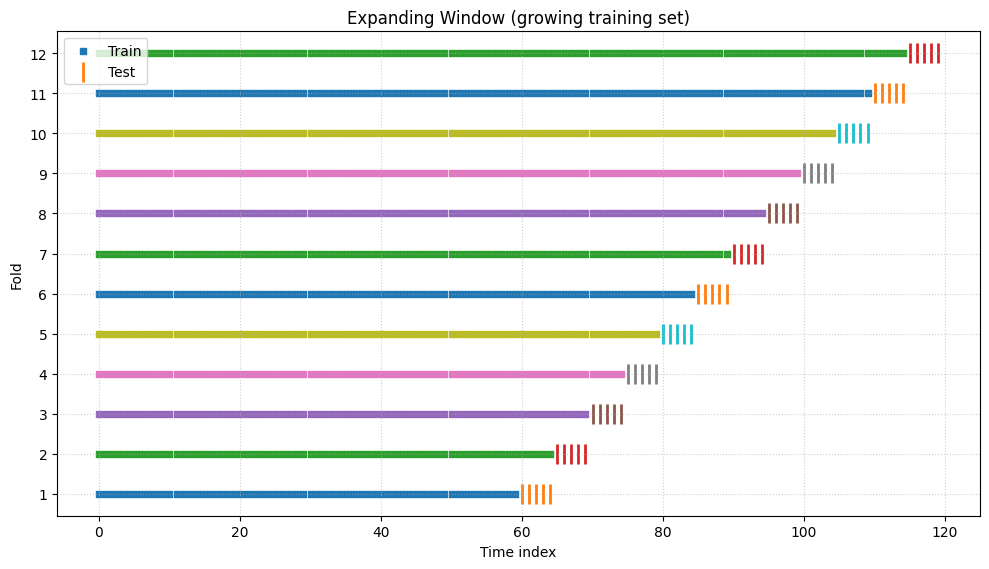

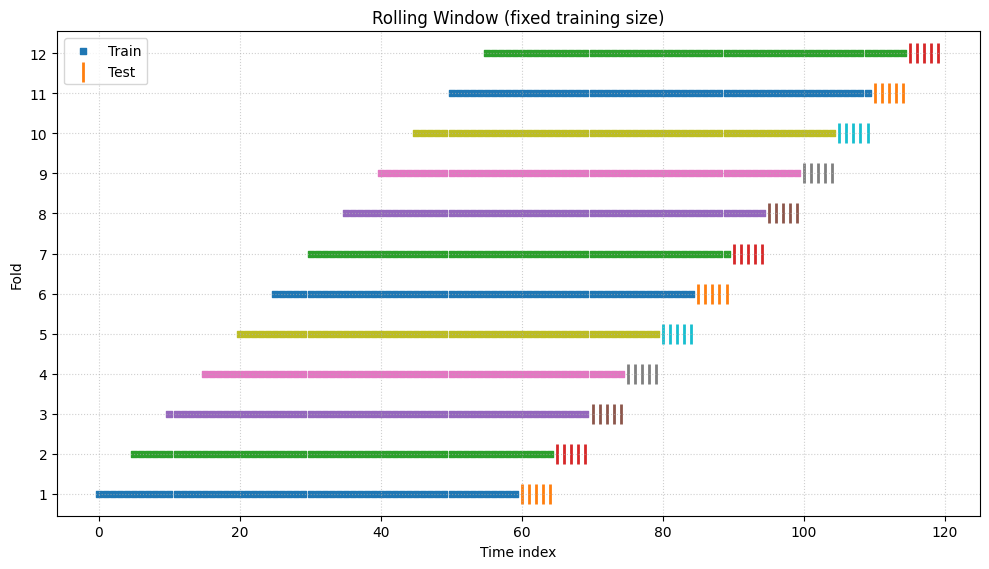

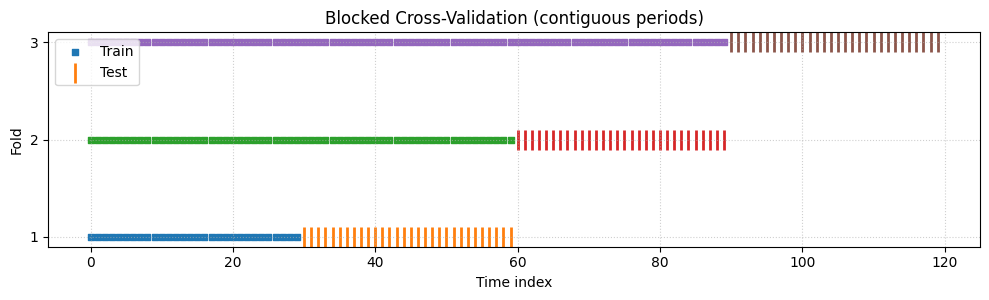

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
def check_no_leakage(train_idx, test_idx):
    if len(train_idx) == 0 or len(test_idx) == 0:
        return False
    return train_idx.max() < test_idx.min()

def plot_splits(splits, title):
    # One chart per method; rows = folds, x = time index
    h = 2.2 + 0.3 * len(splits)
    fig, ax = plt.subplots(figsize=(10, h))
    for i, (train, test) in enumerate(splits, start=1):
        # Train shown as squares; Test as vertical bars
        ax.scatter(train, np.full_like(train, i), marker='s', s=20, label='Train' if i == 1 else None)
        ax.scatter(test, np.full_like(test, i), marker='|', s=200, linewidths=2, label='Test' if i == 1 else None)
    ax.set_title(title)
    ax.set_xlabel("Time index")
    ax.set_ylabel("Fold")
    ax.set_yticks(range(1, len(splits) + 1))
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Split generators (robust, no leakage)
# -----------------------------
def expanding_splits(n, initial=60, horizon=5, step=5):
    """Train = [0 : end), Test = [end : end+horizon); end grows by step."""
    splits = []
    end = initial
    while end + horizon <= n:
        train = np.arange(0, end)
        test  = np.arange(end, end + horizon)
        if check_no_leakage(train, test):
            splits.append((train, test))
        end += step
    return splits

def rolling_splits(n, window=60, horizon=5, step=5):
    """Train = [end-window : end), fixed-size; Test = [end : end+horizon)."""
    splits = []
    end = window
    while end + horizon <= n:
        train = np.arange(end - window, end)
        test  = np.arange(end, end + horizon)
        if check_no_leakage(train, test):
            splits.append((train, test))
        end += step
    return splits

def blocked_splits(n, n_blocks=4):
    """
    Contiguous blocks; fold i trains on blocks [:i], tests on block i.
    Ensures distinct time segments. Last block becomes final test.
    """
    blocks = np.array_split(np.arange(n), n_blocks)
    splits = []
    for i in range(1, n_blocks):
        train = np.concatenate(blocks[:i])
        test  = blocks[i]
        if check_no_leakage(train, test):
            splits.append((train, test))
    return splits

# -----------------------------
# Demo parameters
# -----------------------------
n = 120       # length of the series (time indices 0..119)
initial = 60  # initial train size
window = 60   # rolling train window size
horizon = 5   # forecast horizon
step = 5      # stride between folds
n_blocks = 4  # blocked CV blocks

# -----------------------------
# Generate splits
# -----------------------------
splits_expanding = expanding_splits(n, initial=initial, horizon=horizon, step=step)
splits_rolling   = rolling_splits(n, window=window, horizon=horizon, step=step)
splits_blocked   = blocked_splits(n, n_blocks=n_blocks)

# -----------------------------
# Plot (one figure per method)
# -----------------------------
plot_splits(splits_expanding, "Expanding Window (growing training set)")
plot_splits(splits_rolling,   "Rolling Window (fixed training size)")
plot_splits(splits_blocked,   "Blocked Cross-Validation (contiguous periods)")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:02<00:00, 120.80s/it]



Top SARIMA candidates by expanding CV (lower is better):
       order seasonal_order    cv_rmse    cv_mae  pairs
0  (2, 1, 2)  (1, 1, 1, 11)   9.153779  7.175576     38
1  (1, 1, 2)  (1, 1, 1, 11)   9.275111  7.184741     38
2  (1, 1, 2)  (0, 1, 1, 11)   9.365601  7.210232     38
3  (1, 0, 1)  (1, 1, 1, 11)   9.388552  7.011540     38
4  (1, 0, 1)  (0, 1, 1, 11)   9.516185  7.237896     38
5  (1, 0, 0)  (1, 1, 1, 11)   9.754548  6.793215     38
6  (1, 0, 0)  (0, 1, 1, 11)  10.091910  6.913457     38
7  (0, 1, 0)  (1, 1, 1, 11)  10.396856  8.327812     38
8  (1, 0, 2)  (1, 1, 1, 11)  10.468099  7.963649     38
9  (2, 1, 0)  (1, 1, 1, 11)  10.509942  8.117504     38

Selected by CV → SARIMA(2, 1, 2)(1, 1, 1, 11) | CV RMSE=9.154 | CV MAE=7.176

Holdout (test) performance on original scale: RMSE=56.612 | MAE=40.882


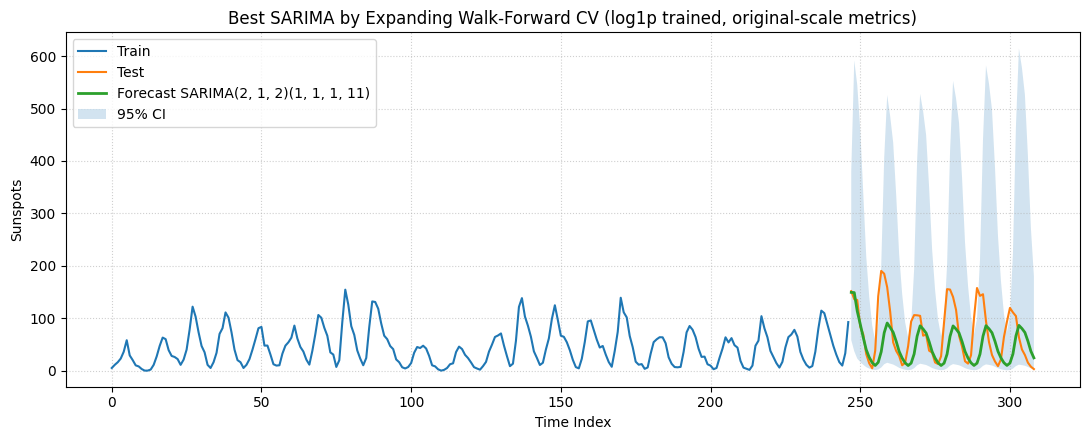

Seasonal naive baseline — Test RMSE=48.573, MAE=38.858


In [27]:
# this code takes about 10 min to run - please be patient
# sarima_cv_sunspots.py
# - Expanding walk-forward CV to select SARIMA(p,d,q)(P,D,Q, s=11)
# - Log1p variance stabilization; metrics on original scale
# - Refit best on train; forecast test with 95% CI and plot

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.datasets import sunspots
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tqdm import tqdm
# -----------------------------
# helpers
# -----------------------------
def expm1_safe(x):
    return np.expm1(np.asarray(x, dtype=float))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def expanding_cv_forecast_sarima(y_log, order, seasonal_order, initial, horizon=1, step=1):
    """
    Walk-forward CV with an expanding training window on LOG scale.
    Returns y_true_orig, y_pred_orig arrays on ORIGINAL scale.
    """
    y_true_o, y_pred_o = [], []
    end = initial
    while end + horizon <= len(y_log):
        train = y_log.iloc[:end]
        test  = y_log.iloc[end:end+horizon]
        try:
            res = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False).fit(
                          disp=False, method_kwargs={"warn_convergence": False})
            fc  = res.forecast(steps=horizon)
            # align and back-transform
            fc.index = test.index
            y_true_o.extend(expm1_safe(test.values))
            y_pred_o.extend(expm1_safe(fc.values))
        except Exception:
            return None, None
        end += step
    return np.array(y_true_o), np.array(y_pred_o)

# -----------------------------
# 1) data & transform
# -----------------------------
data = sunspots.load_pandas().data
y = pd.Series(data["SUNACTIVITY"].astype(float).values,
              index=pd.RangeIndex(len(data)), name="sunspots")

# log1p to stabilize variance; keep original for plotting later
y_log = np.log1p(y)

# split 80/20
split = int(len(y) * 0.8)
y_train, y_test = y.iloc[:split], y.iloc[split:]
y_train_log, y_test_log = y_log.iloc[:split], y_log.iloc[split:]

# -----------------------------
# 2) CV grid (keep compact for speed/robustness)
# -----------------------------
p_grid = [0, 1, 2]
d_grid = [0, 1]
q_grid = [0, 1, 2]
P_grid = [0, 1]
D_grid = [1]          # seasonal differencing is important here
Q_grid = [0, 1]
s = 11                # sunspot cycle ~11 years

initial = max(120, int(len(y_train_log) * 0.7))
horizon = 1
step    = 2

rows = []
for p in tqdm(p_grid):
    for d in d_grid:
        for q in q_grid:
            for P in P_grid:
                for D in D_grid:
                    for Q in Q_grid:
                        order = (p, d, q)
                        seas  = (P, D, Q, s)
                        yt_o, yp_o = expanding_cv_forecast_sarima(
                            y_train_log, order, seas, initial=initial, horizon=horizon, step=step
                        )
                        if yt_o is None or len(yt_o) == 0:
                            continue
                        rows.append({
                            "order": order,
                            "seasonal_order": seas,
                            "cv_rmse": rmse(yt_o, yp_o),
                            "cv_mae":  mae(yt_o, yp_o),
                            "pairs": len(yt_o)
                        })

res = pd.DataFrame(rows).sort_values(["cv_rmse", "cv_mae"]).reset_index(drop=True)
print("\nTop SARIMA candidates by expanding CV (lower is better):")
print(res.head(10))

best_order         = tuple(res.iloc[0]["order"])
best_seasonal      = tuple(res.iloc[0]["seasonal_order"])
best_cv_rmse       = res.iloc[0]["cv_rmse"]
best_cv_mae        = res.iloc[0]["cv_mae"]
print(f"\nSelected by CV → SARIMA{best_order}{best_seasonal} | "
      f"CV RMSE={best_cv_rmse:.3f} | CV MAE={best_cv_mae:.3f}")

# -----------------------------
# 3) refit best on train (log), forecast test, back-transform
# -----------------------------
best = SARIMAX(y_train_log, order=best_order, seasonal_order=best_seasonal,
               enforce_stationarity=False, enforce_invertibility=False).fit(
               disp=False, method_kwargs={"warn_convergence": False})

fc = best.get_forecast(steps=len(y_test))
fc_mean_log = fc.predicted_mean
fc_ci_log   = fc.conf_int(alpha=0.05)

# back to original scale
fc_mean = pd.Series(expm1_safe(fc_mean_log.values), index=y_test.index, name="forecast")
ci_lower = expm1_safe(fc_ci_log.iloc[:, 0].values)
ci_upper = expm1_safe(fc_ci_log.iloc[:, 1].values)

test_RMSE = rmse(y_test.values, fc_mean.values)
test_MAE  = mae(y_test.values,  fc_mean.values)
print(f"\nHoldout (test) performance on original scale:"
      f" RMSE={test_RMSE:.3f} | MAE={test_MAE:.3f}")

# -----------------------------
# 4) plot train/test + forecast w/ 95% CI (original scale)
# -----------------------------
plt.figure(figsize=(11, 4.5))
plt.plot(y_train.index, y_train.values, label="Train")
plt.plot(y_test.index,  y_test.values,  label="Test")
plt.plot(fc_mean.index, fc_mean.values, label=f"Forecast SARIMA{best_order}{best_seasonal}", linewidth=2)
plt.fill_between(fc_mean.index, ci_lower, ci_upper, alpha=0.2, label="95% CI")
plt.title("Best SARIMA by Expanding Walk-Forward CV (log1p trained, original-scale metrics)")
plt.xlabel("Time Index"); plt.ylabel("Sunspots")
plt.legend(); plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------
# 5) (optional) quick seasonal naive baseline for context
# -----------------------------
# Forecast y_t ≈ y_{t-s}
y_sn = y_train.iloc[-s:].to_numpy()
sn_pred = []
for i in range(len(y_test)):
    sn_pred.append(y_train.iloc[-s + (i % s)])
sn_pred = np.array(sn_pred)
print(f"Seasonal naive baseline — Test RMSE={rmse(y_test.values, sn_pred):.3f}, "
      f"MAE={mae(y_test.values, sn_pred):.3f}")
